# Carbon System Data Analysis

---
### Purpose
The purpose of this notebook is to analyze and validate the performance of the Sunburst Sensors, LLC. SAMI-pH (PHSEN) pH, SAMI-pCO$_{2}$ seawater measurements, and the Pro-Oceanus pCO2 sensor measurements at the Global Irminger Array. This is done on a deployment-by-deployment, site-by-site comparison with the pH measurements from discete water samples collected by Niskin Bottle casts during deployment and recovery of the instrumentation during mooring maintainence. 

---
### Background
The Ocean Observatories Initiative (OOI) is an NSF-funded project for long-term (25 years) infrastructure for ocean observations. There are three main elements of OOI: (1) The Regional Cabled Array off the coast of Washington; (2) the Endurance Array on the Oregon-Washington shelf; and (3) the Coastal & Global Scale Nodes with mooring arrays in the Irminger Sea (Irminger Sea Array), at Ocean Station Papa (Papa Array), in the Southern Ocean and Argentine Basin (descoped and no longer collecting data), and at the New England Shelf (Pioneer Array-NES).

This notebook makes use of the carbon system datasets from the Global Irminger Array (60$^{\circ}$N, 39$^{\circ}$W). The Global Irminger Array is composed of four moorings arrayed in a triangle. At the Apex are a hybrid profiling mooring and an Apex Surface Mooring. At the other two vertices are two subsurface moorings, Flanking Moorings A & B. The profiling mooring does not have any carbon system instruments. The Flanking Moorings each have a Sunburst SAMI-pH located at 30 m depth. The Surface Mooring has a Pro-Oceanus CO2-Pro ATM on the surface mooring, Sunburst SAMI-CO2 instruments at 12 m, 40 m, 80 m, and 130 m depth, and Sunbrust SAMI-pH at 20 m and 100 m depth.

---
### Data

#### Bottle Data
These are discrete water samples collected via Niskin Bottle casts during deployment and recovery of the moored instrumentation. The data is downloaded from OOI Alfresco website as excel files. Parameters sampled include oxygen, salinity, nutrient concentrations (phosphate, nitrate, nitrite, ammonium, silicate), chlorophyll concentrations, and the carbon system. The carbon system parameters sampled are Total Alkalinity (TA), Dissolved Inorganic Carbon (DIC), and pH. These data have been prepared using the **```Bottle_Data```** notebook.

#### Deployment Information
For each instrument reference designator, we can get much more detailed information on the deployment numbers, deployment and recovery times, as well as  for a particular reference designator by requesting the deployment information from OOINet. The Deployment information contains the relevant latitude, longitude, and deployed depth information needed to match bottle data with the instrument data.

#### Annotations
Annotations are Human-in-the-loop assessments which provide information on data quality, performance, technical inssues, and context for a given reference designator. They are added by the array operators for specified time periods. Furthermore, they may also be flagged with a "quality flag" indicating if the data should be discarded. Annotations are downloaded right from the OOI data portal as a json file by reference designator and date.

#### PHSEN 
These are the Sunburst Sensors, LLC. SAMI-pH sensor. It is calibrated for pH values from 70-9.0 pH units for salinities from 25-40 psu. Manufacturers stated accuracy of 0.003 pH units, precision < 0.001 pH units, and long-term drift of < 0.001 pH units / 6 months. The data is downloaded from the Ocean Observatories data portal (OOINet) as netCDF files and have been prepared using the **```Identify_and_Download```** notebook. The **```PHSEN```** datasets from Irminger which are used in this notebook are:

#### PCO2W 
These are the Sunburst Sensors, LLC. SAMI-CO<sub>2</sub> sensor. It is calibrated for pCO<sub>2</sub> concentrations from 200 - 1000 ppm or 1200 ppm. Manufacturers stated accuracy of 3 ppm, precision < 1 ppm, and long-term drift of < 1 ppm / 6 months. The data is downloaded from the Ocean Observatories data portal (OOINet) as netCDF files and have been prepared using the **```Identify_and_Download```** notebook. The **```PCO2W```** datasets from Irminger which are used in this notebook are:

#### PCO2A
This is the Pro-Oceanus CO2-Pro ATM sensor. It measures both surface ocean and atmospheric pCO<sub>2</sub> concentrations. The data is downloaded from the Ocean Observatories data portal (OOINet) as netCDF files and have been prepared using the **```Identify_and_Download```** notebook. There is a single **```PCO2A```** dataset from the Irminger Array Apex Surface Mooring:

#### CTDBP
These are the collocated SeaBird CTDs with the **```PHSEN```** and **```PCO2W```** datasets. This is because the carbon system datasets from OOI are not delivered with temperature (T), salinity (S), pressure (P), or density ($\rho$) needed to compare with the bottle data hydrographic parameters. Additionally, the salinity data is used as an input for calculating the pH from the SAMI-pH. The data is downloaded from the Ocean Observatories data portal (OOINet) as netCDF files and have been prepared using the **```Identify_and_Download```** notebook. The **```CTD```** datasets from Irminger which are used in this notebook are:


---
### Methods

#### Dataset Preparation
First, the Bottle Data

#### PCO2W Processing
Verifying the in-situ pCO<sub>2</sub> measured by the PCO2W against the pCO<sub>2</sub> calculated from the discrete water samples TA and DIC requires several preprocessing steps of the PCO2W datasets. First, the netCDF datasets are opened using ```xarray``` into an xarray ```dataset``` object and the primary dimension set to 'time'. Next, T, S, P, and $\rho$ are interpolated to the PCO2W time base using xarray ```ds.interp_like``` from the dataset from the collocated CTDBP. Next, the pCO2 is corrected for hydrostatic pressure using a correction of 15% per 1000 dbar pressure (Enns 1965, Reed et al. 2018). Then the first and last four days of PCO2W data are selected. The standard deviation of the selected pCO2 is calculated using the first-order differencing with a time-lag of one, in order to arrive at a quasi-stationary time series.

#### CTDBP Processing
The associated CTD datasets to the PCO2W are opened using ```xarray``` into an xarray ```dataset``` object and the primary dimension set to 'time'. The CTD dataset T, S, P, and $\rho$ are interpolated to the PCO2W time base and merged into the PCO2W dataset using ```ds.interp_like```. 

#### Discrete Water Samples Processing
The relevant deployment and recovery cruise data for comparison with the PCO2W dataset(s) are opened and loaded into a pandas ```DataFrame``` object. Next, the pCO<sub>2</sub> concentrations are calculated using the ```CO2SYS``` package from the associated TA and DIC concentrations. The bottle samples are then filtered by cruise, time, and depth to identify the samples associated with the deployment and recovery of the PCO2W dataset being analyzed.

#### Sample Matching
Now, we want to identify the Bottle Data which corresponds to the instrument datasets and match the bottle data to the instrument data. First, we request the deployment information for a given instrument dataset in order to get the latitude, longitude, and depth of the instrument. Then, we filter the bottle data for those samples which were collected within 5 km horizontally and 15 m vertically of the instrument data. 

Finally, we generate a table that directly compares the bottle data with the instrument data. We do this by first iterating over each row of the identified bottle data. For each bottle sample, we then take an average of the instrument data which occured within a week of the bottle sample. We save that data in a dataframe along with the associated sample window, deployment number, and important hydrographic parameters (temperature, salinity, pressure).

In [1]:
import os, sys, gc
import json
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Import the OOI M2M tool
sys.path.append("/home/andrew/Documents/OOI-CGSN/ooinet/ooinet/")
from m2m import M2M

In [4]:
sys.path.append("../../OS2022/OS2022/")
from utils import *

#### Set OOINet API access
In order access and download data from OOINet, need to have an OOINet api username and access token. Those can be found on your profile after logging in to OOINet. Your username and access token should NOT be stored in this notebook/python script (for security). It should be stored in a yaml file, kept in the same directory, named user_info.yaml.

In [5]:
# Import user info for connecting to OOINet via M2M
userinfo = yaml.load(open("../../../../QAQC_Sandbox/user_info.yaml"), Loader=yaml.FullLoader)
username = userinfo["apiname"]
token = userinfo["apikey"]

#### Connect to OOINet

In [6]:
OOINet = M2M(username, token)

---
## Discrete Bottle Data

#### Irminger Sea
First, load the bottle data from the Irminger Sea Array into a pandas dataframe. This dataset was prepared using the **```Bottle_Data```** Jupyter notebook. Once the data is loaded, then we'll do some datatype conversions, such as converting the Dates and Times into pandas datetime objects, as well as replacing the fill value of ```-9999999``` with NaNs. Finally, we'll drop the data from the table that doesn't have any DIC, Alkalinity, or pH data to get the relevant carbon system data we'll need for comparisons.

We'll also want to check the associated bottle and discrete sample flags. If the bottle data has been processed using the **```Bottle_Data```** notebook, then the Flags for the Discrete and CTD data parameters have been converted into WOCE standard:
* 1 = good data
* 2 = no evaluation
* 3 = questionable data
* 4 = bad data
* 9 = missing/no data

First, we'll load some functions for interacting witht he bottle data from **```bottle_utils.py```** module.

In [7]:
from bottle_utils import *

In [8]:
bottleData = pd.read_csv("../data/water_sampling/Irminger_Bottle_Data.csv")
bottleData

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pCO2 [lab conditions],Calculated pH [lab conditions]
0,AR35-05,8,Gliders,59.844167,-39.094567,2019-08-10 20:33:00+00:00,8,*0000000000000001,2824.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AR35-05,8,Gliders,59.844167,-39.094567,2019-08-10 20:33:00+00:00,8,*0000000000000001,2824.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AR35-05,8,Gliders,59.844167,-39.094567,2019-08-10 20:33:00+00:00,8,*0000000000000001,2824.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AR35-05,9,"GI01SUMO, GI02HYPM",59.965767,-39.565850,2019-08-11 16:43:00+00:00,9,*0000000000000001,2654.0,NaN,...,NaN,NaN,NaN,NaN,35.044331,1.329078,1039.400834,1039.400834,NaN,NaN
4,AR35-05,9,"GI01SUMO, GI02HYPM",59.965767,-39.565850,2019-08-11 16:43:00+00:00,9,*0000000000000001,2654.0,NaN,...,NaN,NaN,NaN,NaN,35.044331,1.329078,1039.400834,1039.400834,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,AR30-03,23,CL2,62.058500,-32.231833,2018-06-22 20:07:00+00:00,23,*0000000000000100,2400.0,D:\Data\ar30-03023.hex,...,NaN,NaN,NaN,NaN,35.050344,5.174898,1028.042319,1028.042319,NaN,NaN
878,AR30-03,23,CL2,62.058500,-32.231833,2018-06-22 20:07:00+00:00,23,*0000000000000100,2400.0,D:\Data\ar30-03023.hex,...,NaN,NaN,NaN,NaN,35.052420,6.910300,1027.540094,1027.540094,NaN,NaN
879,AR30-03,23,CL2,62.058500,-32.231833,2018-06-22 20:07:00+00:00,23,*0000000000000100,2400.0,D:\Data\ar30-03023.hex,...,NaN,NaN,NaN,NaN,35.054759,7.243608,1027.416413,1027.416413,NaN,NaN
880,AR30-03,23,CL2,62.058500,-32.231833,2018-06-22 20:07:00+00:00,23,*0000000000000100,2400.0,D:\Data\ar30-03023.hex,...,NaN,NaN,NaN,NaN,35.048232,7.269356,1027.370393,1027.370393,NaN,NaN


In [9]:
def convert_times(x):
    if type(x) is str:
        x = pd.to_datetime(x, utc=False)
    else:
        pass
    
    return x

In [10]:
bottleData["Start Time [UTC]"] = bottleData["Start Time [UTC]"].apply(lambda x: convert_times(x))
bottleData["CTD Bottle Closure Time [UTC]"] = bottleData["CTD Bottle Closure Time [UTC]"].apply(lambda x: convert_times(x))

With the flags interpreted to simpler scheme, can now filter the data to keep only the "good" and "suspicious" data. We'll replace the bad or missing data with NaNs so we can drop them in the next step

In [11]:
# ====================================================
# Irminger Sea data
mask = (bottleData["Discrete Alkalinity Flag"] != 1) & (bottleData["Discrete Alkalinity Flag"] != 3)
to_replace = bottleData["Discrete Alkalinity [umol/kg]"][mask].dropna().unique()
bottleData["Discrete Alkalinity [umol/kg]"].replace(to_replace=to_replace, value=np.nan, inplace=True)

mask = (bottleData["Discrete DIC Flag"] != 1) & (bottleData["Discrete DIC Flag"] != 3)
to_replace = bottleData["Discrete DIC [umol/kg]"][mask].dropna().unique()
bottleData["Discrete DIC [umol/kg]"].replace(to_replace=to_replace, value=np.nan, inplace=True)

mask = (bottleData["Discrete pH Flag"] != 1) & (bottleData["Discrete pH Flag"] != 3)
to_replace = bottleData["Discrete pH [Total scale]"][mask].dropna().unique()
bottleData["Discrete pH [Total scale]"].replace(to_replace=to_replace, value=np.nan, inplace=True)

Drop rows with NaNs in the carbon system data, since those don't have any relevant data

In [12]:
carbon_columns = ["Discrete Alkalinity [umol/kg]", "Discrete DIC [umol/kg]", "Discrete pH [Total scale]"]
carbonData = bottleData.dropna(subset=carbon_columns, how="all")

---
## PCO2A

First, we examine the **```PCO2A```** dataset from the Irminger Surface Mooring Buoy. The **```PCO2A```** is the Pro-Oceanus CO2-Pro ATM instrument. It samples both the surface ocean and atmospheric pCO<sub>2</sub>. There is one **```PCO2A```** at the Irminger Array.

Import some custom plotting functions for this notebook

In [13]:
sys.path.append("../../")
from OS2022.OS2022 import plotting

Load the dataset which has been prepared using the **```Identify_and_Download_Data```** notebook

In [14]:
pco2a = xr.open_dataset("../data/GI01SUMO-SBD12-04-PCO2AA000_combined.nc", chunks="auto")
pco2a

<xarray.Dataset>
Dimensions:                               (time: 204483)
Coordinates:
  * time                                  (time) datetime64[ns] 2014-09-10T19...
Data variables: (12/31)
    air_temperature                       (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    avg_irga_temperature                  (time) float32 dask.array<chunksize=(204483,), meta=np.ndarray>
    barometric_pressure                   (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    current_a2d                           (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    deployment                            (time) int32 dask.array<chunksize=(204483,), meta=np.ndarray>
    gas_stream_pressure                   (time) float32 dask.array<chunksize=(204483,), meta=np.ndarray>
    ...                                    ...
    relative_humidity                     (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    rollup_annotations_qc_results         (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    sea_surface_temperature               (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    shortwave_irradiance                  (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    supply_voltage                        (time) float32 dask.array<chunksize=(204483,), meta=np.ndarray>
    zero_a2d                              (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
Attributes: (12/70)
    node:                               SBD12
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             pco2a_a_dcl_instrument_water
    ...                                 ...
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                59.9337
    lon:                                -39.47378
    Location_name:                      Global Irminger Sea Apex Surface Moor...

Text(0.5, 1.0, 'GI01SUMO-SBD12-04-PCO2AA000')

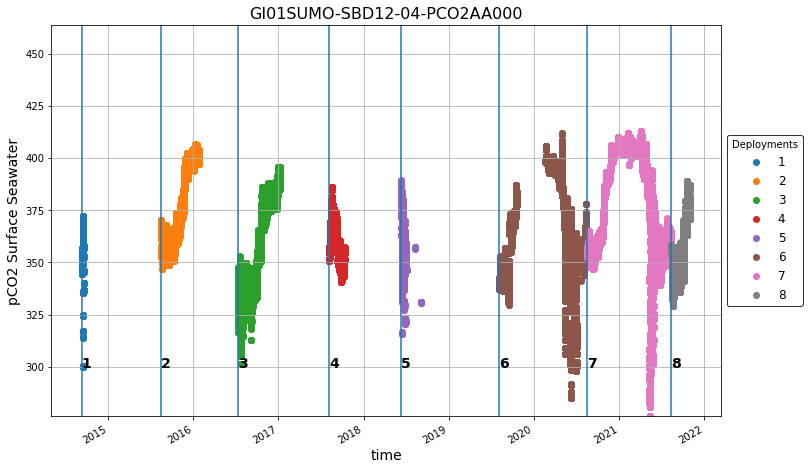

In [15]:
# Plot the data as a function of deployments
fig, ax = plotting.plot_variable(pco2a, "partial_pressure_co2_ssw")
ax.set_title("GI01SUMO-SBD12-04-PCO2AA000", fontsize=16)

In [16]:
fig.savefig("../results/GI01SUMO-SBD12-04-PCO2AA000/time_series.png")

### Annotations
Next, request the annotations for the **```PCO2A```** dataset

In [17]:
annotations = OOINet.get_annotations("GI01SUMO-SBD12-04-PCO2AA000")
annotations

,@class,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters
0,.AnnotationRecord,46,GI01SUMO,None,None,None,None,1423958400000,1.440202e+12,Deployment 1: Status data sent from the buoy i...,False,lgarzio@marine.rutgers.edu,0,[]
1,.AnnotationRecord,47,GI01SUMO,None,None,None,None,1453852800000,1.468886e+12,Deployment 2: A period of violent weather caus...,False,lgarzio@marine.rutgers.edu,0,[]
2,.AnnotationRecord,121,GI01SUMO,None,None,None,None,1482796800000,1.491523e+12,Deployment 3: Wind turbines were disabled due ...,False,lgarzio@marine.rutgers.edu,0,[]
3,.AnnotationRecord,686,GI01SUMO,SBD12,04-PCO2AA000,None,None,1410375000000,1.411572e+12,Deployment 1: The tubing to the pump was missi...,False,lgarzio@marine.rutgers.edu,0,[]
4,.AnnotationRecord,102,GI01SUMO,None,None,None,None,1501957020000,1.528963e+12,Deployment 4: at 10:03 UTC on 12 October 2017 ...,False,lgarzio@marine.rutgers.edu,0,[]
5,.AnnotationRecord,1743,GI01SUMO,None,None,telemetered,None,1571702400000,1.598438e+12,Deployment 6: *UPDATED 2020-04-27: As of 2020-...,False,cdobson@whoi.edu,0,[]
6,.AnnotationRecord,1481,GI01SUMO,SBD12,04-PCO2AA000,None,None,1530741480000,1.565338e+12,Deployment 5: Instrument stopped sending valid...,False,lgarzio@marine.rutgers.edu,9,[]
7,.AnnotationRecord,1625,GI01SUMO,None,None,None,None,1560988800000,1.565338e+12,Deployment 5: Battery voltage dropped below 24...,False,cdobson@whoi.edu,0,[]
8,.AnnotationRecord,2255,GI01SUMO,SBD12,None,None,None,1593648000000,1.595290e+12,Deployment 6: Due to power generation concerns...,False,cdobson@whoi.edu,0,[]
9,.AnnotationRecord,3328,GI01SUMO,SBD12,None,None,None,1635957000000,NaN,Deployment 8: DCL12 power was disabled 11/3/20...,False,cdobson@whoi.edu,9,[]


#### Add Annotation Information to dataset
With the annotations, use the built-in function from the **```OOINet```** module to add them to the dataset.

In [18]:
pco2a = OOINet.add_annotation_qc_flag(pco2a, annotations)
pco2a

<xarray.Dataset>
Dimensions:                               (time: 204483)
Coordinates:
  * time                                  (time) datetime64[ns] 2014-09-10T19...
Data variables: (12/31)
    air_temperature                       (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    avg_irga_temperature                  (time) float32 dask.array<chunksize=(204483,), meta=np.ndarray>
    barometric_pressure                   (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    current_a2d                           (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    deployment                            (time) int32 dask.array<chunksize=(204483,), meta=np.ndarray>
    gas_stream_pressure                   (time) float32 dask.array<chunksize=(204483,), meta=np.ndarray>
    ...                                    ...
    relative_humidity                     (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    rollup_annotations_qc_results         (time) float64 0.0 0.0 0.0 ... 0.0 0.0
    sea_surface_temperature               (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    shortwave_irradiance                  (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
    supply_voltage                        (time) float32 dask.array<chunksize=(204483,), meta=np.ndarray>
    zero_a2d                              (time) float64 dask.array<chunksize=(204483,), meta=np.ndarray>
Attributes: (12/70)
    node:                               SBD12
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             pco2a_a_dcl_instrument_water
    ...                                 ...
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                59.9337
    lon:                                -39.47378
    Location_name:                      Global Irminger Sea Apex Surface Moor...

Plot the data with the annotations highlighted

Text(0.5, 1.0, 'GI01SUMO-SBD12-04-PCO2AA000')

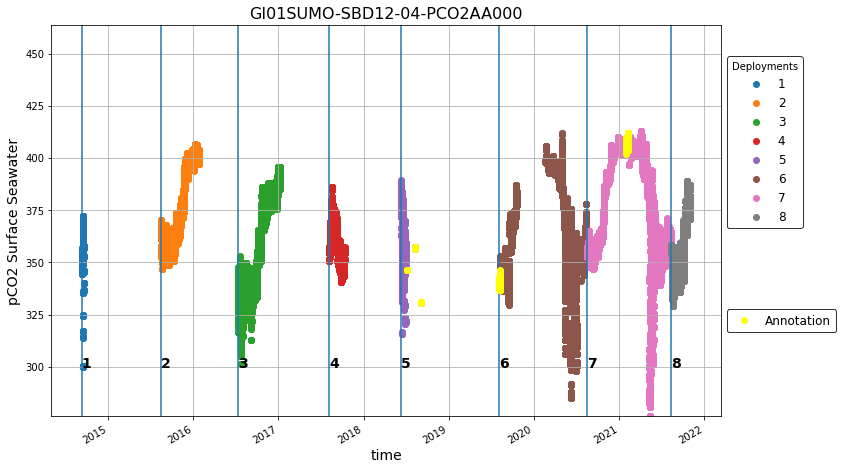

In [19]:
# Plot the data as a function of deployments
fig, ax = plotting.plot_variable(pco2a, "partial_pressure_co2_ssw")

# Plot figure which highlights data points with a corresponding annotation
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s, = ax.plot(pco2a.time.where(pco2a.rollup_annotations_qc_results == 9), 
             pco2a.partial_pressure_co2_ssw.where(pco2a.rollup_annotations_qc_results == 9), 
             marker="o", linestyle="", color="yellow", label="Annotation")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_title("GI01SUMO-SBD12-04-PCO2AA000", fontsize=16)

In [20]:
# fig.savefig("../results/GI01SUMO-SBD12-04-PCO2AA000/time_series_with_annotations.png")

#### Filter Annotations
Finally, we can remove the data flagged by the annotations from the dataset. However, for the purposes of this analysis, I chose to *not* remove the flagged data.

In [21]:
# pco2a = pco2a.where(pco2a.rollup_annotations_qc_results != 9, drop=True)
# pco2a

<xarray.Dataset>
Dimensions:                               (time: 201558)
Coordinates:
  * time                                  (time) datetime64[ns] 2014-09-10T19...
Data variables: (12/31)
    air_temperature                       (time) float64 dask.array<chunksize=(201558,), meta=np.ndarray>
    avg_irga_temperature                  (time) float32 dask.array<chunksize=(201558,), meta=np.ndarray>
    barometric_pressure                   (time) float64 dask.array<chunksize=(201558,), meta=np.ndarray>
    current_a2d                           (time) float64 dask.array<chunksize=(201558,), meta=np.ndarray>
    deployment                            (time) float64 dask.array<chunksize=(201558,), meta=np.ndarray>
    gas_stream_pressure                   (time) float32 dask.array<chunksize=(201558,), meta=np.ndarray>
    ...                                    ...
    relative_humidity                     (time) float64 dask.array<chunksize=(201558,), meta=np.ndarray>
    rollup_annotations_qc_results         (time) float64 0.0 0.0 0.0 ... 0.0 0.0
    sea_surface_temperature               (time) float64 dask.array<chunksize=(201558,), meta=np.ndarray>
    shortwave_irradiance                  (time) float64 dask.array<chunksize=(201558,), meta=np.ndarray>
    supply_voltage                        (time) float32 dask.array<chunksize=(201558,), meta=np.ndarray>
    zero_a2d                              (time) float64 dask.array<chunksize=(201558,), meta=np.ndarray>
Attributes: (12/70)
    node:                               SBD12
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             pco2a_a_dcl_instrument_water
    ...                                 ...
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                59.9337
    lon:                                -39.47378
    Location_name:                      Global Irminger Sea Apex Surface Moor...

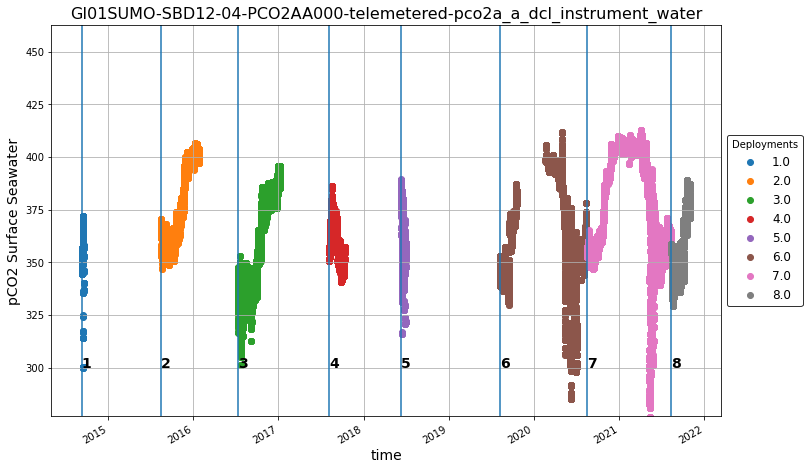

In [22]:
# fig, ax = plotting.plot_variable(pco2a, "partial_pressure_co2_ssw")

#### Match Bottle Data with PCO2A Data
Now, we want to identify the Bottle Data which corresponds to **```PCO2A```** datasets and match the bottle data to the **```PCO2A```** data. First, we request the deployment information for the **```PCO2A```** dataset in order to get the latitude, longitude, and depth of the instrument. Then, we filter the bottle data for data which was collected within 5 km horizontally and 15 m vertically of the **```PCO2A```** data. Finally, we generate a table of comparing the bottle data with the **```PCO2A```**. We do this by iterating over each row of the identified bottle data. For each bottle sample, we then take an average of the **```PCO2A```** pCO2 which occured within a week of the bottle sample to get the instrument pCO2.

In [23]:
deployments = OOINet.get_deployments("GI01SUMO-SBD12-04-PCO2AA000")
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,8,CGINS-PCO2AA-34232,3648,59.946233,-39.57565,0.0,2021-08-12 17:04:00,NaT,AR60-01,None
0,7,CGINS-PCO2AA-35263,1715,59.935683,-39.471917,0.0,2020-08-17 17:34:00,2021-08-19 06:49:00,AR46,AR60-01
0,6,CGINS-PCO2AA-35262,1717,59.945118,-39.57401,0.0,2019-08-05 15:29:00,2020-08-26 10:41:00,AR35-05,AR46
0,5,CGINS-PCO2AA-34223,3491,59.93295,-39.46549,0.0,2018-06-08 17:21:00,2019-08-09 08:04:00,AR30-03,AR35-05
0,4,CGINS-PCO2AA-35261,1705,59.9449,-39.5751,0.0,2017-08-05 18:17:00,2017-10-12 09:07:00,AR21,UNRECOVERED
0,3,CGINS-PCO2AA-34229,3635,59.9341,-39.4673,0.0,2016-07-10 17:44:00,2017-08-14 09:33:00,AR7-01,AR21
0,2,CGINS-PCO2AA-34233,3650,59.94358,-39.57372,0.0,2015-08-15 19:22:00,2016-07-19 10:09:00,AT30-01,AR7-01
0,1,CGINS-PCO2AA-33177,2194,59.9337,-39.47378,0.0,2014-09-10 18:50:00,2015-08-22 11:00:00,KN221-04,AT30-01


In [24]:
lat, lon, depth = deployments["latitude"].mean(), deployments["longitude"].mean(), deployments["depth"].mean()
lat, lon, depth

(59.939533, -39.52212087499999, 0.0)

Identify the bottle samples which are associated with samples collected near the PHSEN instrument we are looking at. Here I utilize a horizontal maximum distance of 5 kilometers and a depth theshold of +/- 10 meters.

In [25]:
pco2a_bottles = findSamples(carbonData, (lat, lon), depth, 5, 15)
pco2a_bottles

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pCO2 [lab conditions],Calculated pH [lab conditions]
10,AR35-05,9,"GI01SUMO, GI02HYPM",59.965767,-39.565850,2019-08-11 16:43:00+00:00,9,*0000000000000001,2654.0,NaN,...,NaN,145.738071,NaN,NaN,34.770743,10.286703,1026.652053,1026.652053,720.162701,7.831473
44,AR35-05,11,"GI01SUMO, GI02HYPM, Gliders",59.968500,-39.578500,2019-08-15 09:06:49+00:00,11,*0000000000000101,2650.0,D:\Data\ar35-05011.hex,...,NaN,146.428431,NaN,NaN,34.810774,10.274055,1026.686945,1026.686945,715.993229,7.833760
47,AR35-05,11,"GI01SUMO, GI02HYPM, Gliders",59.968500,-39.578500,2019-08-15 09:06:49+00:00,11,*0000000000000101,2650.0,D:\Data\ar35-05011.hex,...,NaN,148.282029,NaN,NaN,34.811008,10.292748,1026.651219,1026.651219,705.262325,7.839594
115,AR7-01,6,SUMO,59.933167,-39.450833,2016-07-10 19:49:21+00:00,6,*0000000000000100,2724.0,D:\Data\ar0701006.hex,...,NaN,163.282139,NaN,NaN,35.017051,8.417905,1027.159284,1027.159284,633.948229,7.883440
187,AR21,7,SUMO,59.926333,-39.516167,2017-08-05 20:24:20+00:00,7,*0000000000000100,2711.0,D:\Data\AR21_007.hex,...,NaN,157.047274,NaN,NaN,34.955449,8.496928,1027.048524,1027.048524,666.461253,7.864683
325,KN221-04,5,GI01SUMO,59.924167,-39.509333,2014-09-11 22:48:32+00:00,5,*0000000000000100,2714.0,C:\Data\ctd\KN22104005.hex,...,NaN,146.321208,NaN,NaN,34.937910,9.185501,1026.979217,1026.979217,714.771183,7.834307
326,KN221-04,5,GI01SUMO,59.924167,-39.509333,2014-09-11 22:48:32+00:00,5,*0000000000000100,2714.0,C:\Data\ctd\KN22104005.hex,...,NaN,147.946373,NaN,NaN,34.938563,9.183489,1026.932278,1026.932278,704.974047,7.839543
601,AR30-03,5,SUMO,59.940500,-39.523000,2018-06-08 18:14:14+00:00,5,*0000000000000100,2702.0,D:\Data\ar30-03005.hex,...,NaN,125.071643,NaN,NaN,35.034969,5.802866,1027.535079,1027.535079,862.148952,7.764278
602,AR30-03,5,SUMO,59.940500,-39.523000,2018-06-08 18:14:14+00:00,5,*0000000000000100,2702.0,D:\Data\ar30-03005.hex,...,NaN,127.785876,NaN,NaN,35.033871,5.818795,1027.486420,1027.486420,841.494013,7.773852


Text(0, 0.5, 'pCO2 Surface Seawater')

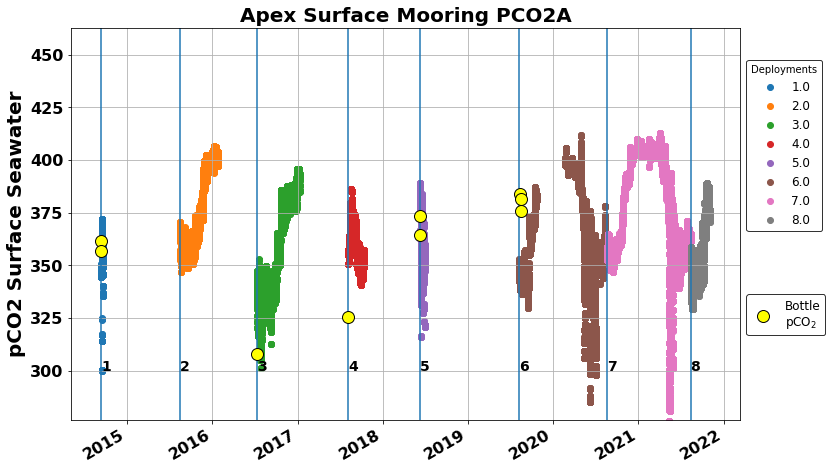

In [38]:
fig, ax = plotting.plot_variable(pco2a, "partial_pressure_co2_ssw")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

s, = ax.plot(pco2a_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Start Time [UTC]"], 
             pco2a_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Calculated pCO2 [uatm]"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle\npCO$_{2}$")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_xlim(xmin, xmax)
ax.set_title("Apex Surface Mooring PCO2A", fontsize=20, weight="bold")
plt.xticks(fontsize=16, weight="bold")
plt.xlabel("")
plt.yticks(fontsize=16, weight="bold")
ylabel = ax.get_ylabel()
plt.ylabel(ylabel, fontsize=20, weight="bold")

In [47]:
ax.get_legend_handles_labels()[0]

In [39]:
fig.savefig("../results/GI01SUMO-SBD12-04-PCO2AA000/time_series_with_discrete_bottles.png", facecolor="white", transparent=False)

Create a time-based filter to get the data from the instrument associated with each of the bottle time stamps so we can do a direct comparison

In [48]:
pco2a_comparison = pd.DataFrame(columns=["deploymentNumber", "time", "bottleCO2", "bottleT", "bottleS", "bottleP",
                                         "CO2_avg", "CO2_std", "T", "S"])

for ind in pco2a_bottles.index:
    # Get the time stamps of a bottle
    t = pco2a_bottles["Start Time [UTC]"].loc[ind]
    t = t.tz_localize(None)

    # Get the bottle pCO2a
    bottleCO2 = pco2a_bottles["Calculated pCO2 [uatm]"].loc[ind]
    bottleT = pco2a_bottles[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].loc[ind].mean(skipna=True)
    bottleS = pco2a_bottles[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].loc[ind].mean(skipna=True)
    bottleP = pco2a_bottles["CTD Pressure [db]"].loc[ind]

    # Create a time window to look for data
    dt = pd.Timedelta(days=7)
    tmin = t - dt
    tmax = t + dt

    # Find the data within the time series
    subset = pco2a.where((pco2a.time >= tmin) & (pco2a.time <= tmax), drop=True)
    # Check for unique deployments
    deps = np.unique(subset.deployment)
    # If more than one deployment, split it based on deployments
    if len(deps) > 1:
        for depNum in deps:
            dep_subset = subset.where(subset.deployment == depNum, drop=True)
            pco2_avg = dep_subset.partial_pressure_co2_ssw.mean().compute().values
            pco2_std = dep_subset.partial_pressure_co2_ssw.std().compute().values
            pco2_temp = dep_subset.sea_surface_temperature.mean().compute().values
            pco2_sal = dep_subset.met_salsurf.mean().compute().values
            pco2a_comparison = pco2a_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "bottleCO2": bottleCO2,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
                "CO2_avg": pco2_avg,
                "CO2_std": pco2_std,
                "T": pco2_temp,
                "S": pco2_sal
            }, ignore_index=True)
    elif len(deps) == 1:
        pco2_avg = subset.partial_pressure_co2_ssw.mean().compute().values
        pco2_std = subset.partial_pressure_co2_ssw.std().compute().values
        pco2_temp = subset.sea_surface_temperature.mean().compute().values
        pco2_sal = subset.met_salsurf.mean().compute().values
        depNum = deps[0]
        pco2a_comparison = pco2a_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "bottleCO2": bottleCO2,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
                "CO2_avg": pco2_avg,
                "CO2_std": pco2_std,
                "T": pco2_temp,
                "S": pco2_sal
            }, ignore_index=True)
    else:
        # Now put in NaNs for the missing results data
        pco2a_comparison = pco2a_comparison.append({
                "deploymentNumber": None,
                "time": t,
                "bottleCO2": bottleCO2,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
                "CO2_avg": None,
                "CO2_std": None,
                "T": None,
                "S": None
            }, ignore_index=True)

pco2a_comparison = pco2a_comparison.append({
                "deploymentNumber": 2,
                "time": None,
                "bottleCO2": None,
                "bottleT": None,
                "bottleS": None,
                "bottleP": None,
                "CO2_avg": None,
                "CO2_std": None,
                "T": None,
                "S": None
            }, ignore_index=True)
# Save the results
pco2a_comparison = pco2a_comparison.sort_values(by="deploymentNumber")
pco2a_comparison


,deploymentNumber,time,bottleCO2,bottleT,bottleS,bottleP,CO2_avg,CO2_std,T,S
5,1.0,2014-09-11 22:48:32,361.754518,9.19295,34.77245,14.837,354.21348524266824,10.953438552897294,8.616887885082598,34.79370316380415
6,1.0,2014-09-11 22:48:32,356.619043,9.18980,34.77295,4.277,354.21348524266824,10.953438552897294,8.616887885082598,34.79370316380415
9,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,2016-07-10 19:49:21,307.717623,8.42625,34.85120,14.150,335.2838245090782,7.312563569339581,8.830039091246714,34.83728692276714
4,4.0,2017-08-05 20:24:20,325.332621,8.50315,34.78975,3.003,359.5102721913028,5.603860596768383,8.717398034294288,34.785554878483836
7,5.0,2018-06-08 18:14:14,373.530565,5.80940,34.86900,12.965,366.5292192105166,17.61187772957166,6.1593062346858085,34.87132583431519
8,5.0,2018-06-08 18:14:14,364.397411,5.82450,34.86780,3.017,366.5292192105166,17.61187772957166,6.1593062346858085,34.87132583431519
0,6.0,2019-08-11 16:43:00,384.021275,10.29100,34.60600,12.000,344.53727718958913,3.228180904694268,10.618052507195609,34.65614407680663
1,6.0,2019-08-15 09:06:49,381.493628,10.27915,34.64585,12.390,343.6679105026661,3.132657051489971,10.576185127043367,34.65466992722693
2,6.0,2019-08-15 09:06:49,375.931426,10.29700,34.64600,5.132,343.6679105026661,3.132657051489971,10.576185127043367,34.65466992722693


(array([260., 280., 300., 320., 340., 360., 380., 400., 420.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

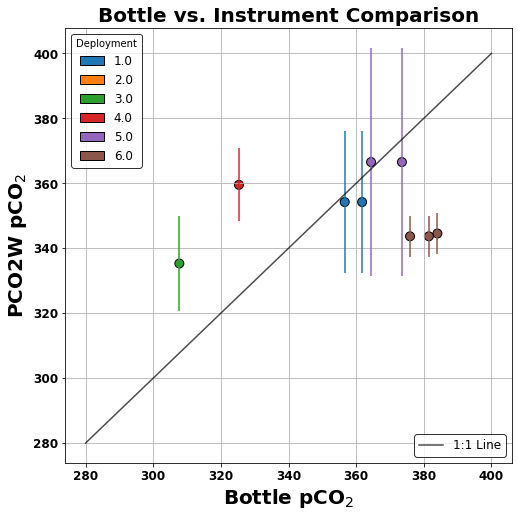

In [167]:
df = pco2a_comparison.dropna(subset=["deploymentNumber"])
df["bottleCO2"] = df["bottleCO2"].astype(float)
df["CO2_avg"] = df["CO2_avg"].astype(float)
df["CO2_std"] = df["CO2_std"].astype(float)
#df = df[df["deploymentNumber"] != 3]

fig, ax = plt.subplots(figsize=(8,8))

# Set the 
levels, categories = pd.factorize(df['deploymentNumber'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data
ax.scatter(df["bottleCO2"], df["CO2_avg"], c=colors, s=80, edgecolors="black")
ax.set_xlabel(xlabel="Bottle pCO$_{2}$", fontsize=20, weight="bold")
ax.set_ylabel(ylabel="PCO2W pCO$_{2}$", fontsize=20, weight="bold")
ax.legend(handles=handles, title='Deployment', fontsize=12, edgecolor="black")
ax.grid()

first_legend = ax.get_legend()
ax.add_artist(first_legend)

# Add in vertical error bars
for i, c in enumerate(categories):
    x = df["bottleCO2"][df["deploymentNumber"] == c]
    ymin = df["CO2_avg"][df["deploymentNumber"] == c] - 2*df["CO2_std"][df["deploymentNumber"] == c]
    ymax = df["CO2_avg"][df["deploymentNumber"] == c] + 2*df["CO2_std"][df["deploymentNumber"] == c]
    ax.vlines(x, ymin, ymax, colors = plt.cm.tab10(i))

#ax.set_ylim((250, 500))
#ax.set_xlim((350, 450))
# Add in a 1:1 line
x = np.arange(280, 405, 5)
y = np.arange(280, 405, 5)
s, = ax.plot(x, y, color = "black", alpha=0.7, label="1:1 Line")
ax.legend(handles=[s], edgecolor="black", loc="lower right", fontsize=12)
ax.set_title("Bottle vs. Instrument Comparison", fontsize=20, weight="bold")
plt.yticks(fontsize=12, weight="bold")
plt.xticks(fontsize=12, weight="bold")

In [168]:
handles

In [169]:
fig.savefig("../results/GI01SUMO-SBD12-04-PCO2AA000/instrument_vs_bottle_co2.png", facecolor="white", transparent=False)

#### Adjust all values to be surface values

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

In [ ]:
subset = pco2a.where(pco2a.deployment == 3, drop=True)
subset

In [ ]:
adfuller_test(subset["partial_pressure_co2_ssw"])

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2,1,1)
fig = plot_acf(subset.partial_pressure_co2_ssw.diff(dim="time"), lags=40, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_pacf(subset.partial_pressure_co2_ssw.diff(dim="time"), lags=40, ax=ax2)

We'll calculate the noise term using a first-difference estimate to get the standard deviation of the data

---
## Instrument Datasets


        
---
## Surface Mooring

| Instrument | Reference Designator | Mooring | Depth |
| ---------- | ------- | ------ | ----- |
| PCO2A      | GI01SUMO-SBD12-04-PCO2AA000 | Apex Surface Mooring | Surface |
| PCO2W      | GI01SUMO-RID16-05-PCO2WB000 | Apex Surface Mooring | 12 m |
| CTDBP      | GI01SUMO-RID16-03-CTDBPF000 | Apex Surface Mooring | 12 m |
| PCO2W      | GI01SUMO-RII11-02-PCO2WC051 | Apex Surface Mooring | 40 m |
| CTDMO      | GI01SUMO-RII11-02-CTDMOQ031 | Apex Surface Mooring | 40 m |
| PCO2W      | GI01SUMO-RII11-02-PCO2WC052 | Apex Surface Mooring | 80 m |
| CTDBP      | GI01SUMO-RII11-02-CTDBPP032 | Apex Surface Mooring | 80 m |
| PCO2W      | GI01SUMO-RII11-02-PCO2WC053 | Apex Surface Mooring | 130 m |
| CTDMP      | GI01SUMO-RII11-02-CTDBPP033 | Apex Surface Mooring | 130 m |
| PHSEN      | GI01SUMO-RII11-02-PHSENE041 | Apex Surface Mooring | 20 m |
| CTDMO      | GI01SUMO-RII11-02-CTDMOQ011 | Apex Surface Mooring | 20 m |
| PHSEN      | GI01SUMO-RII11-02-PHSENE042 | Apex Surface Mooring | 100 m |
| CTDMO      | GI01SUMO-RII11-02-CTDMOQ013 | Apex Surface Mooring | 100 m |
| PHSEN      | GI03FLMA-RIS01-04-PHSENF000 | Flanking Mooring A | 30 m |
| CTDMO      | GI03FLMA-RIM01-02-CTDMOG040 | Flanking Mooring A | 30 m |
| PHSEN      | GI01SUMO-RII11-02-CTDMOQ013 | Flanking Mooring B | 30 m |
| CTDMO      | GI01SUMO-RII11-02-CTDMOQ013 | Flanking Mooring B | 30 m |


---
## PCO2W

Next, we want to go over the available PCO2W datasets at the Irminger Mooring. The available datasets are:

| Instrument | Reference Designator | Mooring | Depth |
| ---------- | ------- | ------ | ----- |
| PCO2W      | GI01SUMO-RID16-05-PCO2WB000 | Apex Surface Mooring | 12 m |
| CTDBP      | GI01SUMO-RID16-03-CTDBPF000 | Apex Surface Mooring | 12 m |
| PCO2W      | GI01SUMO-RII11-02-PCO2WC051 | Apex Surface Mooring | 40 m |
| CTDMO      | GI01SUMO-RII11-02-CTDMOQ031 | Apex Surface Mooring | 40 m |
| PCO2W      | GI01SUMO-RII11-02-PCO2WC052 | Apex Surface Mooring | 80 m |
| CTDBP      | GI01SUMO-RII11-02-CTDBPP032 | Apex Surface Mooring | 80 m |
| PCO2W      | GI01SUMO-RII11-02-PCO2WC053 | Apex Surface Mooring | 130 m |
| CTDMP      | GI01SUMO-RII11-02-CTDBPP033 | Apex Surface Mooring | 130 m |



Import some functions from **```ooi_data_explorations```** to 

In [57]:
from OS2022.OS2022 import process_pco2w, process_phsen

Text(0.5, 1.0, 'GI01SUMO-RII11-02-PCO2WC051')

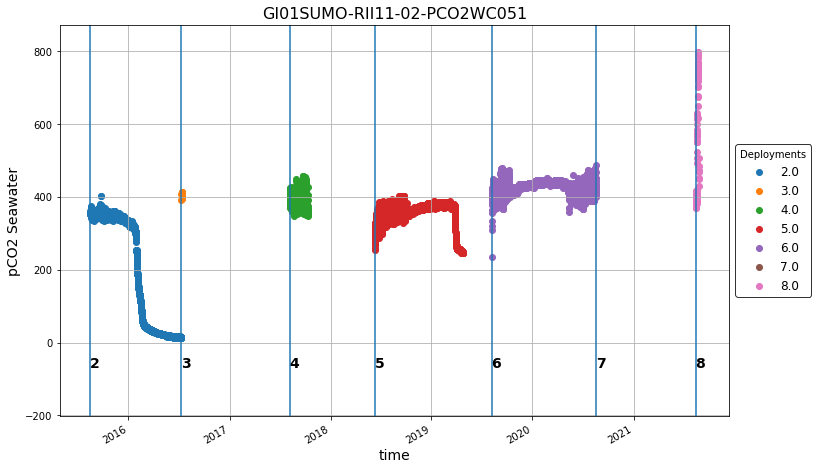

In [58]:
# Set the reference designator
refdes = "GI01SUMO-RII11-02-PCO2WC051"

# Load the PCO2W
pco2w_40m = xr.open_dataset("../data/GI01SUMO-RII11-02-PCO2WC051_combined.nc", chunks="auto")

# Request the annotations
annotations = OOINet.get_annotations("GI01SUMO-RII11-02-PCO2WC051")

# Add the annotations to the dataset
pco2w_40m = OOINet.add_annotation_qc_flag(pco2w_40m, annotations)

# Remove the data flagged as "questionable" from the annotations
# pco2w_40m = pco2w_40m.where(pco2w_40m.rollup_annotations_qc_results != 9, drop=True)

# Plot the first look
fig, ax = plotting.plot_variable(pco2w_40m, "pco2_seawater")
ax.set_title(refdes, fontsize=16)

Save the figure

In [59]:
if not os.path.exists(f"../results/{refdes}/"):
    os.makedirs(f"../results/{refdes}/")

fig.savefig(f"../results/{refdes}/time_series.png")

#### Add in the CTD Data

In [60]:
ctdbpp_40m = xr.open_dataset("../data/GI01SUMO-RII11-02-CTDBPP031_combined.nc", chunks="auto")

In [61]:
practical_salinity = ctdbpp_40m["practical_salinity"].interp_like(pco2w_40m)
seawater_temperature = ctdbpp_40m["ctdbp_seawater_temperature"].interp_like(pco2w_40m)
seawater_pressure = ctdbpp_40m["ctdbp_seawater_pressure"].interp_like(pco2w_40m)
temp = ctdbpp_40m["temp"]

# Add to the pco2w
pco2w_40m["practical_salinity"] = practical_salinity
pco2w_40m["seawater_temperature"] = seawater_temperature
pco2w_40m["seawater_pressure"] = seawater_pressure
pco2w_40m["temp"] = temp

#### Quality Checks
Next, add in the quality checks for the data

In [62]:
qc_flags = process_pco2w.quality_checks(pco2w_40m)
pco2w_40m["qc_flags"] = qc_flags

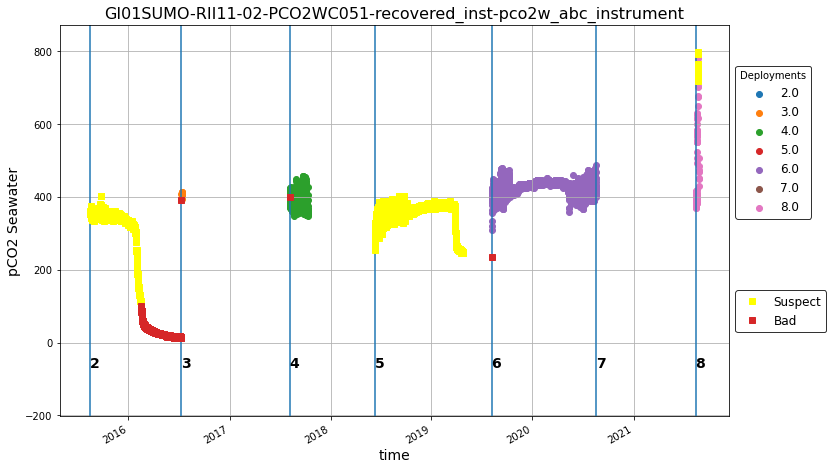

In [63]:
fig, ax = plotting.plot_variable(pco2w_40m, "pco2_seawater")

# Plot figure which highlights data points with a corresponding annotation
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s1, = ax.plot(pco2w_40m.time.where(pco2w_40m.qc_flags == 3), 
             pco2w_40m.pco2_seawater.where(pco2w_40m.qc_flags == 3), 
             marker="s", linestyle="", color="yellow", label="Suspect")
s2, = ax.plot(pco2w_40m.time.where(pco2w_40m.qc_flags == 4), 
             pco2w_40m.pco2_seawater.where(pco2w_40m.qc_flags == 4), 
             marker="s", linestyle="", color="tab:red", label="Bad")

ax.legend(handles=[s1, s2], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)

In [64]:
if not os.path.exists(f"../results/{refdes}/"):
    os.makedirs(f"../results/{refdes}/")

fig.savefig(f"../results/{refdes}/time_series_with_quality_flags.png")

Find the associated bottle samples with this dataset:

In [66]:
deployments = OOINet.get_deployments("GI01SUMO-RII11-02-PCO2WC051")

lat, lon, depth = deployments["latitude"].mean(), deployments["longitude"].mean(), deployments["depth"].mean()
lat, lon, depth

(59.94036628571428, -39.529026714285706, 40.0)

In [67]:
pco2w_40m_bottles = findSamples(carbonData, (lat, lon), depth, 5, 20)

(16552.83552083333, 18973.70635416667)

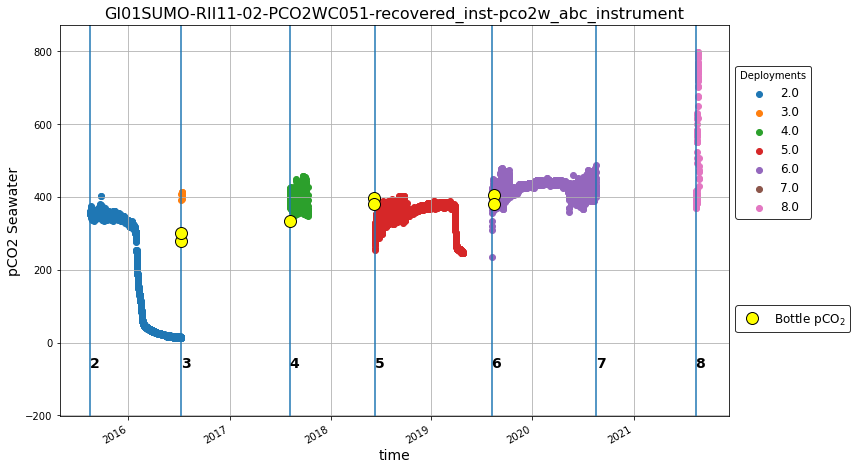

In [68]:
fig, ax = plotting.plot_variable(pco2w_40m, "pco2_seawater")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

s, = ax.plot(pco2w_40m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Start Time [UTC]"], 
             pco2w_40m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Calculated pCO2 [uatm]"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle pCO$_{2}$")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_xlim(xmin, xmax)

In [69]:
if not os.path.exists(f"../results/{refdes}/"):
    os.makedirs(f"../results/{refdes}/")

fig.savefig(f"../results/{refdes}/time_series_with_discrete_bottles.png")

In [70]:
pco2w_40m_comparison = pd.DataFrame(columns=["deploymentNumber", "time", "CO2_avg", "CO2_std", "T", "S", "P",
                                             "bottleCO2", "bottleT", "bottleS", "bottleP"])

for ind in pco2w_40m_bottles.index:
    # Get the time stamps of a bottle
    t = pco2w_40m_bottles["Start Time [UTC]"].loc[ind]
    t = t.tz_localize(None)

    # Get the bottle pCO2a
    bottleCO2 = pco2w_40m_bottles["Calculated pCO2 [uatm]"].loc[ind]
    bottleT = pco2w_40m_bottles[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].loc[ind].mean(skipna=True)
    bottleS = pco2w_40m_bottles[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].loc[ind].mean(skipna=True)
    bottleP = pco2w_40m_bottles["CTD Pressure [db]"].loc[ind]

    # Create a time window to look for data
    dt = pd.Timedelta(days=7)
    tmin = t - dt
    tmax = t + dt

    # Find the data within the time series
    subset = pco2w_40m.where((pco2w_40m.time >= tmin) & (pco2w_40m.time <= tmax), drop=True)
    # Check for unique deployments
    deps = np.unique(subset.deployment)
    # If more than one deployment, split it based on deployments
    if len(deps) > 1:
        for depNum in deps:
            dep_subset = subset.where(subset.deployment == depNum, drop=True)
            pco2_avg = dep_subset.pco2_seawater.mean(skipna=True).compute().values
            pco2_std = dep_subset.pco2_seawater.std(skipna=True).compute().values
            pco2_temp = dep_subset.seawater_temperature.mean(skipna=True).compute().values
            pco2_sal = dep_subset.practical_salinity.mean(skipna=True).compute().values
            pco2_pres = dep_subset.seawater_pressure.mean(skipna=True).compute().values
            pco2w_40m_comparison = pco2w_40m_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "CO2_avg": pco2_avg,
                "CO2_std": pco2_std,
                "T": pco2_temp,
                "S": pco2_sal,
                "P": pco2_pres,
                "bottleCO2": bottleCO2,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)
    elif len(deps) == 1:
        pco2_avg = subset.pco2_seawater.mean(skipna=True).compute().values
        pco2_std = subset.pco2_seawater.std(skipna=True).compute().values
        pco2_temp = subset.seawater_temperature.mean(skipna=True).compute().values
        pco2_sal = subset.practical_salinity.mean(skipna=True).compute().values
        pco2_pres = subset.seawater_pressure.mean(skipna=True).compute().values
        depNum = deps[0]
        pco2w_40m_comparison = pco2w_40m_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "CO2_avg": pco2_avg,
                "CO2_std": pco2_std,
                "T": pco2_temp,
                "S": pco2_sal,
                "P": pco2_pres,
                "bottleCO2": bottleCO2,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)
    else:
        # Now put in NaNs for the missing results data
        pco2w_40m_comparison = pco2w_40m_comparison.append({
                "deploymentNumber": None,
                "time": t,
                "CO2_avg": None,
                "CO2_std": None,
                "T": None,
                "S": None,
                "P": None,
                "bottleCO2": bottleCO2,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)

# Save the results
pco2w_40m_comparison = pco2w_40m_comparison.sort_values(by="deploymentNumber")
pco2w_40m_comparison

,deploymentNumber,time,CO2_avg,CO2_std,T,S,P,bottleCO2,bottleT,bottleS,bottleP
2,2.0,2016-07-10 19:49:21,15.543597,1.2087659,nan,nan,nan,278.410501,5.18445,34.91250,41.089
4,2.0,2016-07-10 19:49:21,15.543597,1.2087659,nan,nan,nan,301.624497,8.03135,34.85445,20.887
3,3.0,2016-07-10 19:49:21,407.1836,6.185375,5.1683289618589585,34.90458632481596,40.764323126067616,278.410501,5.18445,34.91250,41.089
5,3.0,2016-07-10 19:49:21,407.1836,6.185375,5.1683289618589585,34.90458632481596,40.764323126067616,301.624497,8.03135,34.85445,20.887
6,4.0,2017-08-05 20:24:20,394.45358,14.474671,4.538395728032119,34.93581234915007,41.14133074609099,334.286237,8.31075,34.78415,24.163
7,5.0,2018-06-08 18:14:14,319.1253,23.767572,5.607242809774244,34.88842293279174,39.82749590284686,395.809721,5.51260,34.90235,41.487
8,5.0,2018-06-08 18:14:14,319.1253,23.767572,5.607242809774244,34.88842293279174,39.82749590284686,380.775286,5.63675,34.87685,21.261
0,6.0,2019-08-15 09:06:49,408.021,19.577784,7.694592912154022,34.71981078614842,40.6990352538004,406.006503,7.88970,34.71225,40.954
1,6.0,2019-08-15 09:06:49,408.021,19.577784,7.694592912154022,34.71981078614842,40.6990352538004,380.642766,10.29370,34.64625,21.040


In [71]:
# Drop deployment 2 data
pco2w_40m_comparison = pco2w_40m_comparison.drop(labels=[2, 4])
pco2w_40m_comparison

,deploymentNumber,time,CO2_avg,CO2_std,T,S,P,bottleCO2,bottleT,bottleS,bottleP
3,3.0,2016-07-10 19:49:21,407.1836,6.185375,5.1683289618589585,34.90458632481596,40.764323126067616,278.410501,5.18445,34.91250,41.089
5,3.0,2016-07-10 19:49:21,407.1836,6.185375,5.1683289618589585,34.90458632481596,40.764323126067616,301.624497,8.03135,34.85445,20.887
6,4.0,2017-08-05 20:24:20,394.45358,14.474671,4.538395728032119,34.93581234915007,41.14133074609099,334.286237,8.31075,34.78415,24.163
7,5.0,2018-06-08 18:14:14,319.1253,23.767572,5.607242809774244,34.88842293279174,39.82749590284686,395.809721,5.51260,34.90235,41.487
8,5.0,2018-06-08 18:14:14,319.1253,23.767572,5.607242809774244,34.88842293279174,39.82749590284686,380.775286,5.63675,34.87685,21.261
0,6.0,2019-08-15 09:06:49,408.021,19.577784,7.694592912154022,34.71981078614842,40.6990352538004,406.006503,7.88970,34.71225,40.954
1,6.0,2019-08-15 09:06:49,408.021,19.577784,7.694592912154022,34.71981078614842,40.6990352538004,380.642766,10.29370,34.64625,21.040


Text(0.5, 1.0, 'GI01SUMO-RII11-02-PCO2WC051 pCO$_{2}$ Comparison')

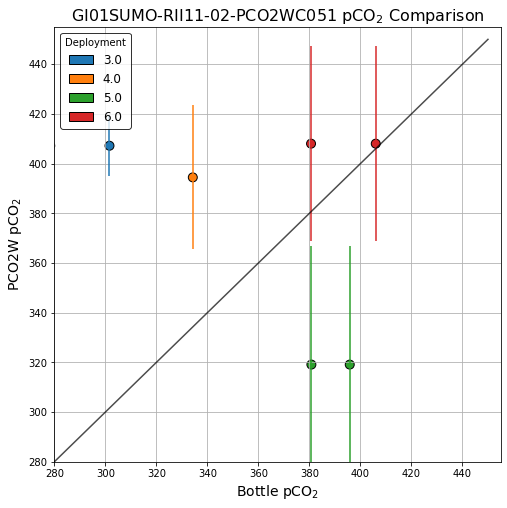

In [72]:
df = pco2w_40m_comparison.dropna(subset=["deploymentNumber"])
df["bottleCO2"] = df["bottleCO2"].astype(float)
df["CO2_avg"] = df["CO2_avg"].astype(float)
df["CO2_std"] = df["CO2_std"].astype(float)
#df = df[df["deploymentNumber"] != 3]

fig, ax = plt.subplots(figsize=(8,8))

# Set the 
levels, categories = pd.factorize(df['deploymentNumber'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data
ax.scatter(df["bottleCO2"], df["CO2_avg"], c=colors, s=80, edgecolors="black")
ax.set_xlabel(xlabel="Bottle pCO$_{2}$", fontsize=14)
ax.set_ylabel(ylabel="PCO2W pCO$_{2}$", fontsize=14)
ax.legend(handles=handles, title='Deployment', fontsize=12, edgecolor="black")
ax.grid()

# Add in vertical error bars
for i, c in enumerate(categories):
    x = df["bottleCO2"][df["deploymentNumber"] == c]
    ymin = df["CO2_avg"][df["deploymentNumber"] == c] - 2*df["CO2_std"][df["deploymentNumber"] == c]
    ymax = df["CO2_avg"][df["deploymentNumber"] == c] + 2*df["CO2_std"][df["deploymentNumber"] == c]
    ax.vlines(x, ymin, ymax, colors = plt.cm.tab10(i))

ax.set_ylim((280, 455))
ax.set_xlim((280, 455))
# Add in a 1:1 line
x = np.arange(280, 455, 5)
y = np.arange(280, 455, 5)
ax.plot(x, y, color = "black", alpha=0.7)
ax.set_title(refdes + " pCO$_{2}$ Comparison", fontsize=16)

In [73]:
fig.savefig(f"../results/{refdes}/instrument_vs_bottle_co2.png")

#### PCO2W 80 m

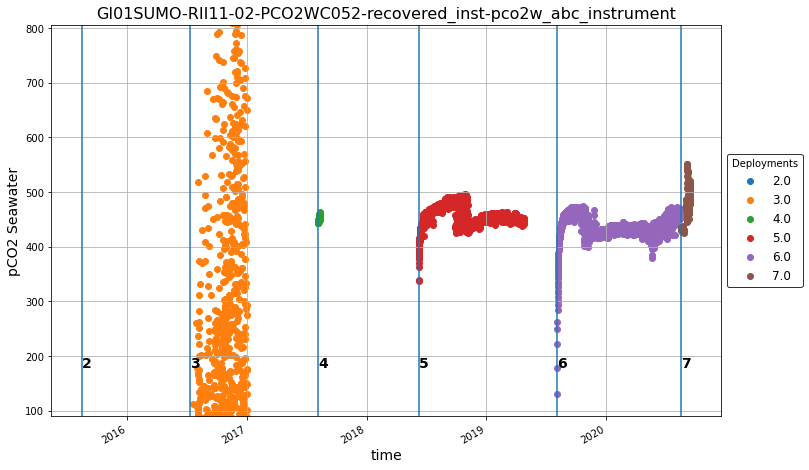

In [74]:
refdes = "GI01SUMO-RII11-02-PCO2W052"

pco2w_80m = xr.open_dataset("../data/GI01SUMO-RII11-02-PCO2WC052_combined.nc", chunks="auto")

annotations = OOINet.get_annotations("GI01SUMO-RII11-02-PCO2WC052")

pco2w_80m = OOINet.add_annotation_qc_flag(pco2w_80m, annotations)

#pco2w_80m = pco2w_80m.where(pco2w_80m.rollup_annotations_qc_results != 9, drop=True)

fig, ax = plotting.plot_variable(pco2w_80m, "pco2_seawater")


In [75]:
if not os.path.exists(f"../results/{refdes}/"):
    os.makedirs(f"../results/{refdes}/")

fig.savefig(f"../results/{refdes}/time_series.png")

#### Add the CTD Data

In [76]:
ctdbpp_80m = xr.open_dataset("../data/GI01SUMO-RII11-02-CTDBPP032_combined.nc", chunks="auto")

In [77]:
practical_salinity = ctdbpp_80m["practical_salinity"].interp_like(pco2w_80m)
seawater_temperature = ctdbpp_80m["ctdbp_seawater_temperature"].interp_like(pco2w_80m)
seawater_pressure = ctdbpp_80m["ctdbp_seawater_pressure"].interp_like(pco2w_80m)

# Add to the pco2w
pco2w_80m["practical_salinity"] = practical_salinity
pco2w_80m["seawater_temperature"] = seawater_temperature
pco2w_80m["seawater_pressure"] = seawater_pressure

#### Quality Checks
Next, add in the quality checks for the data

In [78]:
qc_flags = process_pco2w.quality_checks(pco2w_80m)
pco2w_80m["qc_flags"] = qc_flags

Text(0.5, 1.0, 'GI01SUMO-RII11-02-PCO2WC052')

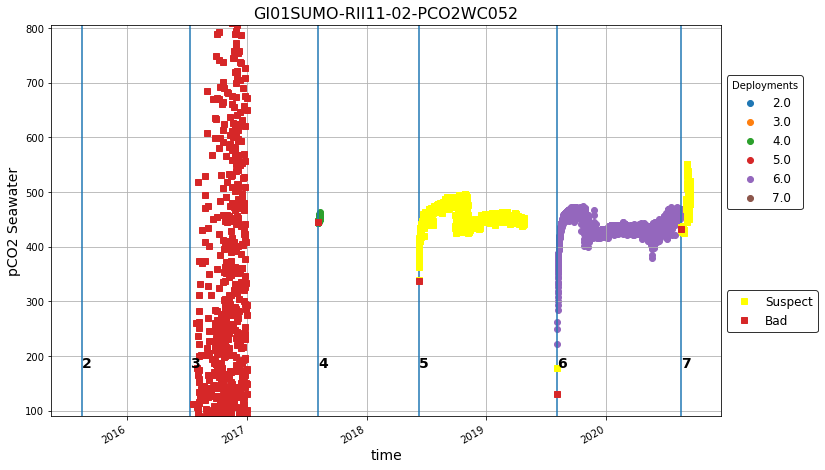

In [79]:
fig, ax = plotting.plot_variable(pco2w_80m, "pco2_seawater")

# Plot figure which highlights data points with a corresponding annotation
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s1, = ax.plot(pco2w_80m.time.where(pco2w_80m.qc_flags == 3), 
             pco2w_80m.pco2_seawater.where(pco2w_80m.qc_flags == 3), 
             marker="s", linestyle="", color="yellow", label="Suspect")
s2, = ax.plot(pco2w_80m.time.where(pco2w_80m.qc_flags == 4), 
             pco2w_80m.pco2_seawater.where(pco2w_80m.qc_flags == 4), 
             marker="s", linestyle="", color="tab:red", label="Bad")

ax.legend(handles=[s1, s2], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_title("GI01SUMO-RII11-02-PCO2WC052", fontsize=16)
#ax.set_ylim((200, 600))

In [80]:
if not os.path.exists(f"../results/{refdes}/"):
    os.makedirs(f"../results/{refdes}/")

fig.savefig(f"../results/{refdes}/time_series_with_quality_flags.png")

Dump the bad data, keep the "questionable" data

In [81]:
#pco2w_80m = pco2w_80m.where(pco2w_80m.qc_flags != 4, drop=True)

Find the associated bottle data

In [82]:
deployments = OOINet.get_deployments("GI01SUMO-RII11-02-PCO2WC052")

lat, lon, depth = deployments["latitude"].mean(), deployments["longitude"].mean(), deployments["depth"].mean()

lat, lon, depth

(59.94036628571428, -39.529026714285706, 80.0)

In [83]:
pco2w_80m_bottles = findSamples(carbonData, (lat, lon), depth, 5, 20)
pco2w_80m_bottles

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pCO2 [lab conditions],Calculated pH [lab conditions]
7,AR35-05,9,"GI01SUMO, GI02HYPM",59.965767,-39.565850,2019-08-11 16:43:00+00:00,9,*0000000000000001,2654.0,NaN,...,NaN,102.485338,NaN,NaN,34.952131,4.970966,1027.885044,1027.885044,1080.159003,7.676956
40,AR35-05,11,"GI01SUMO, GI02HYPM, Gliders",59.968500,-39.578500,2019-08-15 09:06:49+00:00,11,*0000000000000101,2650.0,D:\Data\ar35-05011.hex,...,NaN,102.010500,NaN,NaN,34.949625,4.917004,1027.893495,1027.893495,1085.936131,7.674937
112,AR7-01,6,SUMO,59.933167,-39.450833,2016-07-10 19:49:21+00:00,6,*0000000000000100,2724.0,D:\Data\ar0701006.hex,...,NaN,119.839544,NaN,NaN,35.102596,4.419188,1028.066005,1028.066005,919.572784,7.743121
184,AR21,7,SUMO,59.926333,-39.516167,2017-08-05 20:24:20+00:00,7,*0000000000000100,2711.0,D:\Data\AR21_007.hex,...,NaN,118.958320,NaN,NaN,35.090857,4.823939,1028.023036,1028.023036,929.434357,7.738829
596,AR30-03,5,SUMO,59.940500,-39.523000,2018-06-08 18:14:14+00:00,5,*0000000000000100,2702.0,D:\Data\ar30-03005.hex,...,NaN,112.072733,NaN,NaN,35.080798,5.156514,1027.967184,1027.967184,982.440955,7.714562


(16570.006354166664, 18613.118854166667)

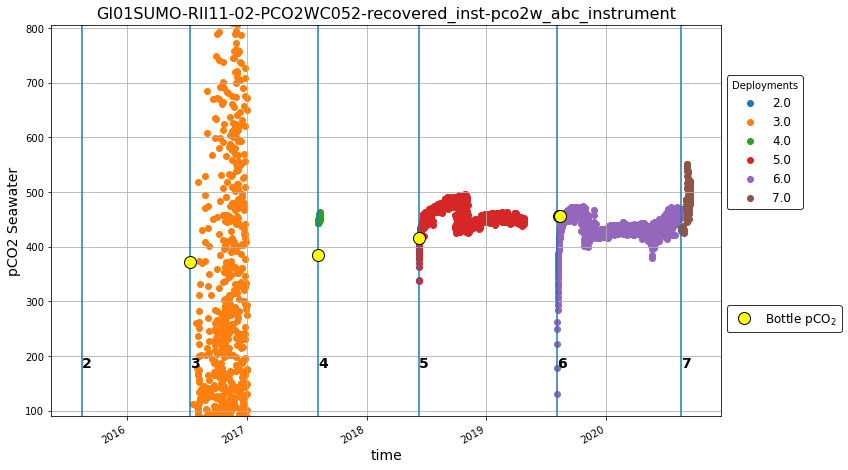

In [84]:
fig, ax = plotting.plot_variable(pco2w_80m, "pco2_seawater")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

s, = ax.plot(pco2w_80m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Start Time [UTC]"], 
             pco2w_80m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Calculated pCO2 [uatm]"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle pCO$_{2}$")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_xlim(xmin, xmax)

In [85]:
if not os.path.exists(f"../results/{refdes}/"):
    os.makedirs(f"../results/{refdes}/")

fig.savefig(f"../results/{refdes}/time_series_with_discrete_bottles.png")

In [86]:
pco2w_80m_comparison = pd.DataFrame(columns=["deploymentNumber", "time", "CO2_avg", "CO2_std", "T", "S", "P",
                                            "bottleCO2", "bottleT", "bottleS", "bottleP"])

for ind in pco2w_80m_bottles.index:
    # Get the time stamps of a bottle
    t = pco2w_80m_bottles["Start Time [UTC]"].loc[ind]
    t = t.tz_localize(None)

    # Get the bottle pCO2a
    bottleCO2 = pco2w_80m_bottles["Calculated pCO2 [uatm]"].loc[ind]
    bottleT = pco2w_80m_bottles[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].loc[ind].mean(skipna=True)
    bottleS = pco2w_80m_bottles[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].loc[ind].mean(skipna=True)
    bottleP = pco2w_80m_bottles["CTD Pressure [db]"].loc[ind]

    # Create a time window to look for data
    dt = pd.Timedelta(days=7)
    tmin = t - dt
    tmax = t + dt

    # Find the data within the time series
    subset = pco2w_80m.where((pco2w_80m.time >= tmin) & (pco2w_80m.time <= tmax), drop=True)
    # Check for unique deployments
    deps = np.unique(subset.deployment)
    # If more than one deployment, split it based on deployments
    if len(deps) > 1:
        for depNum in deps:
            dep_subset = subset.where(subset.deployment == depNum, drop=True)
            pco2_avg = dep_subset.pco2_seawater.mean().compute().values
            pco2_std = dep_subset.pco2_seawater.std().compute().values
            pco2_temp = dep_subset.seawater_temperature.mean().compute().values
            pco2_sal = dep_subset.practical_salinity.mean().compute().values
            pco2_pres = dep_subset.seawater_pressure.mean().compute().values
            pco2w_80m_comparison = pco2w_80m_comparison.append({
                    "deploymentNumber": depNum,
                    "time": t,
                    "CO2_avg": pco2_avg,
                    "CO2_std": pco2_std,
                    "T": pco2_temp,
                    "S": pco2_sal,
                    "P": pco2_pres,
                    "bottleCO2": bottleCO2,
                    "bottleT": bottleT,
                    "bottleS": bottleS,
                    "bottleP": bottleP,
                }, ignore_index=True)
    elif len(deps) == 1:
        pco2_avg = subset.pco2_seawater.mean().compute().values
        pco2_std = subset.pco2_seawater.std().compute().values
        pco2_temp = subset.seawater_temperature.mean().compute().values
        pco2_sal = subset.practical_salinity.mean().compute().values
        pco2_pres = subset.seawater_pressure.mean().compute().values
        depNum = deps[0]
        pco2w_80m_comparison = pco2w_80m_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "CO2_avg": pco2_avg,
                "CO2_std": pco2_std,
                "T": pco2_temp,
                "S": pco2_sal,
                "P": pco2_pres,
                "bottleCO2": bottleCO2,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)
    else:
        # Now put in NaNs for the missing results data
        pco2w_80m_comparison = pco2w_80m_comparison.append({
                "deploymentNumber": None,
                "time": t,
                "CO2_avg": None,
                "CO2_std": None,
                "T": None,
                "S": None,
                "P": None,
                "bottleCO2": bottleCO2,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)

# Save the results
pco2w_80m_comparison = pco2w_80m_comparison.sort_values(by="deploymentNumber")
pco2w_80m_comparison

,deploymentNumber,time,CO2_avg,CO2_std,T,S,P,bottleCO2,bottleT,bottleS,bottleP
2,3.0,2016-07-10 19:49:21,nan,nan,4.254190202244276,34.92455388484801,82.86434040266006,372.676300,4.43005,34.93575,80.786
3,4.0,2017-08-05 20:24:20,451.35294,4.489527,4.849771801131644,34.945394479666426,81.67768852146028,384.659935,4.83555,34.92405,83.499
4,5.0,2018-06-08 18:14:14,411.9022,21.21636,5.283961476551793,34.89553392366022,80.20585734588795,415.232251,5.16840,34.91405,81.656
0,6.0,2019-08-11 16:43:00,399.82593,50.679794,4.075329211373808,34.80775780335521,97.41024413162745,455.568470,4.98100,34.78600,81.000
1,6.0,2019-08-15 09:06:49,426.47693,20.405834,4.081820661097246,34.80853361067924,97.27695946306018,456.968168,4.92700,34.78350,81.883


In [87]:
pco2w_80m_comparison.loc[0,"deploymentNumber"] = 3
pco2w_80m_comparison.loc[1,"deploymentNumber"] = 4
pco2w_80m_comparison

,deploymentNumber,time,CO2_avg,CO2_std,T,S,P,bottleCO2,bottleT,bottleS,bottleP
2,3.0,2016-07-10 19:49:21,nan,nan,4.254190202244276,34.92455388484801,82.86434040266006,372.676300,4.43005,34.93575,80.786
3,4.0,2017-08-05 20:24:20,451.35294,4.489527,4.849771801131644,34.945394479666426,81.67768852146028,384.659935,4.83555,34.92405,83.499
4,5.0,2018-06-08 18:14:14,411.9022,21.21636,5.283961476551793,34.89553392366022,80.20585734588795,415.232251,5.16840,34.91405,81.656
0,3.0,2019-08-11 16:43:00,399.82593,50.679794,4.075329211373808,34.80775780335521,97.41024413162745,455.568470,4.98100,34.78600,81.000
1,4.0,2019-08-15 09:06:49,426.47693,20.405834,4.081820661097246,34.80853361067924,97.27695946306018,456.968168,4.92700,34.78350,81.883


Text(0.5, 1.0, 'GI01SUMO-RII11-02-PCO2W052 pCO$_{2}$ Comparison')

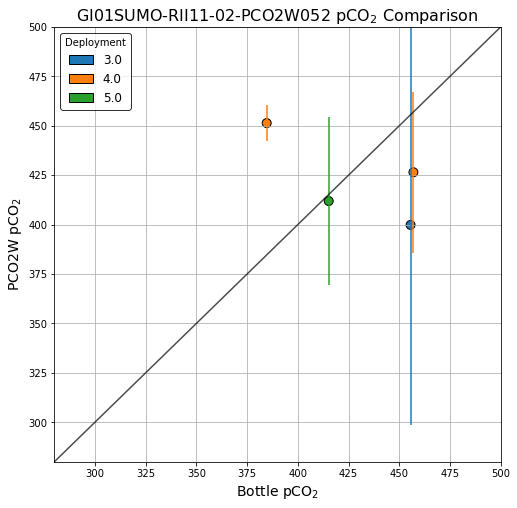

In [88]:
df = pco2w_80m_comparison.dropna(subset=["deploymentNumber"])
df["bottleCO2"] = df["bottleCO2"].astype(float)
df["CO2_avg"] = df["CO2_avg"].astype(float)
df["CO2_std"] = df["CO2_std"].astype(float)
#df = df[df["deploymentNumber"] != 3]

fig, ax = plt.subplots(figsize=(8,8))

# Set the 
levels, categories = pd.factorize(df['deploymentNumber'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data
ax.scatter(df["bottleCO2"], df["CO2_avg"], c=colors, s=80, edgecolors="black")
ax.set_xlabel(xlabel="Bottle pCO$_{2}$", fontsize=14)
ax.set_ylabel(ylabel="PCO2W pCO$_{2}$", fontsize=14)
ax.legend(handles=handles, title='Deployment', fontsize=12, edgecolor="black")
ax.grid()

# Add in vertical error bars
for i, c in enumerate(categories):
    x = df["bottleCO2"][df["deploymentNumber"] == c]
    ymin = df["CO2_avg"][df["deploymentNumber"] == c] - 2*df["CO2_std"][df["deploymentNumber"] == c]
    ymax = df["CO2_avg"][df["deploymentNumber"] == c] + 2*df["CO2_std"][df["deploymentNumber"] == c]
    ax.vlines(x, ymin, ymax, colors = plt.cm.tab10(i))

ax.set_ylim((280, 500))
ax.set_xlim((280, 500))
# Add in a 1:1 line
x = np.arange(280, 505, 5)
y = np.arange(280, 505, 5)
ax.plot(x, y, color = "black", alpha=0.7)
ax.set_title(refdes + " pCO$_{2}$ Comparison", fontsize=16)

In [89]:
fig.savefig(f"../results/{refdes}/instrument_vs_bottle_co2.png")

#### PCO2W 130m

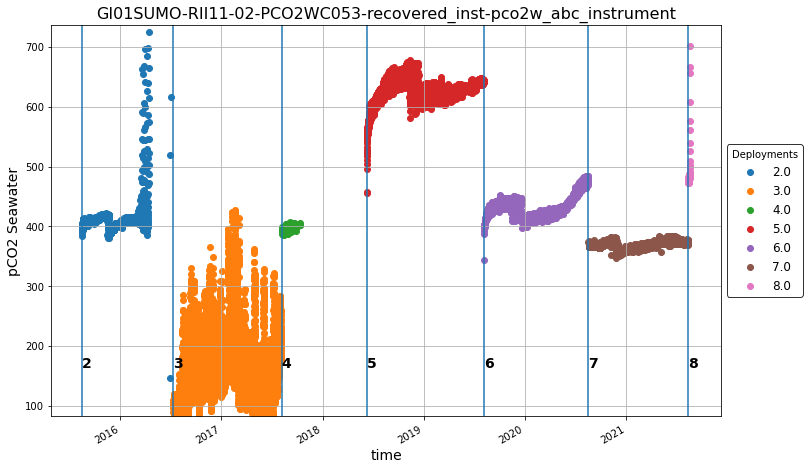

In [90]:
refdes = "GI01SUMO-RII11-02-PCO2WC053"

pco2w_130m = xr.open_dataset(f"../data/{refdes}_combined.nc", chunks="auto")

annotations = OOINet.get_annotations(refdes)

pco2w_130m = OOINet.add_annotation_qc_flag(pco2w_130m, annotations)

#pco2w_130m = pco2w_130m.where(pco2w_130m.rollup_annotations_qc_results != 9, drop=True)

fig, ax = plotting.plot_variable(pco2w_130m, "pco2_seawater")

In [91]:
if not os.path.exists(f"../results/{refdes}/"):
    os.makedirs(f"../results/{refdes}/")

fig.savefig(f"../results/{refdes}/time_series.png")

#### Add CTD Data

In [92]:
ctdbpp_130m = xr.open_dataset("../data/GI01SUMO-RII11-02-CTDBPP033_combined.nc", chunks="auto")

In [93]:
practical_salinity = ctdbpp_130m["practical_salinity"].interp_like(pco2w_130m)
seawater_temperature = ctdbpp_130m["ctdbp_seawater_temperature"].interp_like(pco2w_130m)
seawater_pressure = ctdbpp_130m["ctdbp_seawater_pressure"].interp_like(pco2w_130m)

# Add to the pco2w
pco2w_130m["practical_salinity"] = practical_salinity
pco2w_130m["seawater_temperature"] = seawater_temperature
pco2w_130m["seawater_pressure"] = seawater_pressure

#### Quality Checks
Next, add in the quality checks for the data

In [94]:
qc_flags = process_pco2w.quality_checks(pco2w_130m)
pco2w_130m["qc_flags"] = qc_flags

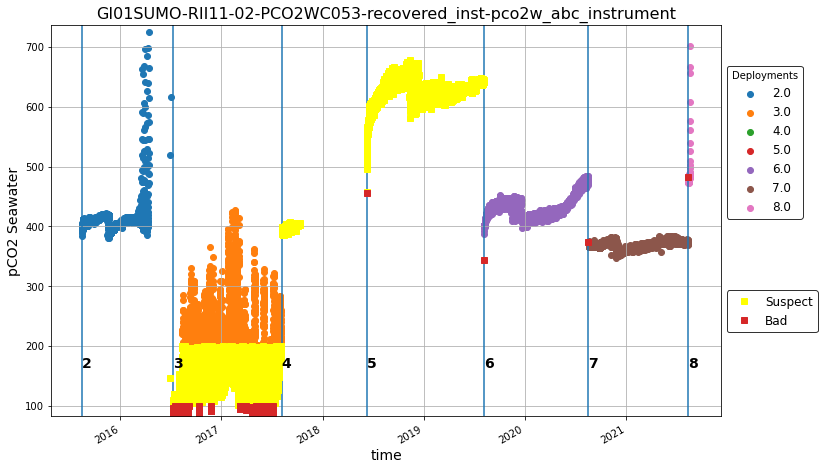

In [95]:
fig, ax = plotting.plot_variable(pco2w_130m, "pco2_seawater")

# Plot figure which highlights data points with a corresponding annotation
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s1, = ax.plot(pco2w_130m.time.where(pco2w_130m.qc_flags == 3), 
             pco2w_130m.pco2_seawater.where(pco2w_130m.qc_flags == 3), 
             marker="s", linestyle="", color="yellow", label="Suspect")
s2, = ax.plot(pco2w_130m.time.where(pco2w_130m.qc_flags == 4), 
             pco2w_130m.pco2_seawater.where(pco2w_130m.qc_flags == 4), 
             marker="s", linestyle="", color="tab:red", label="Bad")

ax.legend(handles=[s1, s2], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)

In [96]:
if not os.path.exists(f"../results/{refdes}/"):
    os.makedirs(f"../results/{refdes}/")

fig.savefig(f"../results/{refdes}/time_series_with_quality_flags.png")

Dump the bad data, keep the "questionable" data

In [97]:
#pco2w_130m = pco2w_130m.where(pco2w_130m.qc_flags != 4, drop=True)

In [98]:
deployments = OOINet.get_deployments(refdes)

lat, lon, depth = deployments["latitude"].mean(), deployments["longitude"].mean(), deployments["depth"].mean()
lat, lon, depth

(59.94036628571428, -39.529026714285706, 130.0)

In [99]:
pco2w_130m_bottles = findSamples(carbonData, (lat, lon), depth, 5, 20)
pco2w_130m_bottles["CTD Pressure [db]"]

109    131.250
181    133.965
593    131.784
Name: CTD Pressure [db], dtype: float64

Text(0.5, 1.0, 'GI01SUMO-RII11-02-PCO2WC053')

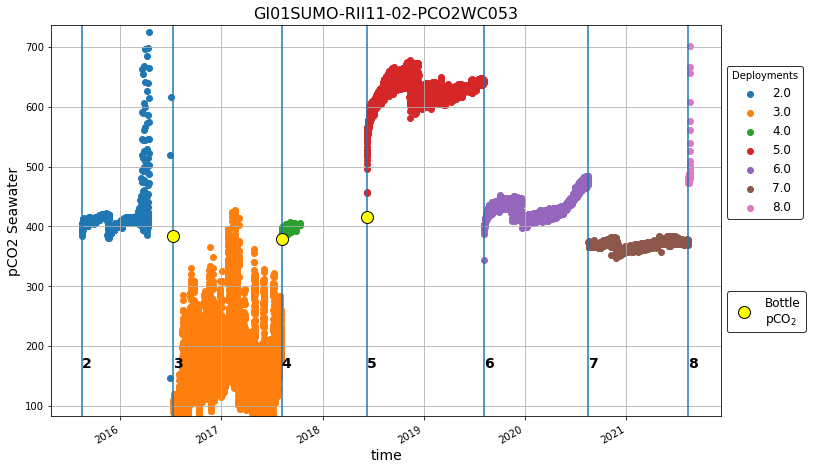

In [100]:
fig, ax = plotting.plot_variable(pco2w_130m, "pco2_seawater")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

s, = ax.plot(pco2w_130m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Start Time [UTC]"], 
             pco2w_130m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Calculated pCO2 [uatm]"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle\npCO$_{2}$")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_xlim(xmin, xmax)
ax.set_title(refdes, fontsize=16)

In [101]:
ax

<AxesSubplot:title={'center':'GI01SUMO-RII11-02-PCO2WC053'}, xlabel='time', ylabel='pCO2 Seawater'>

In [102]:
if not os.path.exists(f"../results/{refdes}/"):
    os.makedirs(f"../results/{refdes}/")

fig.savefig(f"../results/{refdes}/time_series_with_discrete_bottles.png")

In [103]:
pco2w_130m_comparison = pd.DataFrame(columns=["deploymentNumber", "time", "CO2_avg", "CO2_std", "T", "S", "P",
                                            "bottleCO2", "bottleT", "bottleS", "bottleP"])

for ind in pco2w_130m_bottles.index:
    # Get the time stamps of a bottle
    t = pco2w_130m_bottles["Start Time [UTC]"].loc[ind]
    t = t.tz_localize(None)

    # Get the bottle pCO2a
    bottleCO2 = pco2w_130m_bottles["Calculated pCO2 [uatm]"].loc[ind]
    bottleT = pco2w_130m_bottles[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].loc[ind].mean(skipna=True)
    bottleS = pco2w_130m_bottles[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].loc[ind].mean(skipna=True)
    bottleP = pco2w_130m_bottles["CTD Pressure [db]"].loc[ind]

    # Create a time window to look for data
    dt = pd.Timedelta(days=7)
    tmin = t - dt
    tmax = t + dt

    # Find the data within the time series
    subset = pco2w_130m.where((pco2w_130m.time >= tmin) & (pco2w_130m.time <= tmax), drop=True)
    # Check for unique deployments
    deps = np.unique(subset.deployment)
    # If more than one deployment, split it based on deployments
    if len(deps) > 1:
        for depNum in deps:
            dep_subset = subset.where(subset.deployment == depNum, drop=True)
            pco2_avg = dep_subset.pco2_seawater.mean().compute().values
            pco2_std = dep_subset.pco2_seawater.std().compute().values
            pco2_temp = dep_subset.seawater_temperature.mean().compute().values
            pco2_sal = dep_subset.practical_salinity.mean().compute().values
            pco2_pres = dep_subset.seawater_pressure.mean().compute().values
            pco2w_130m_comparison = pco2w_130m_comparison.append({
                    "deploymentNumber": depNum,
                    "time": t,
                    "CO2_avg": pco2_avg,
                    "CO2_std": pco2_std,
                    "T": pco2_temp,
                    "S": pco2_sal,
                    "P": pco2_pres,
                    "bottleCO2": bottleCO2,
                    "bottleT": bottleT,
                    "bottleS": bottleS,
                    "bottleP": bottleP,
                }, ignore_index=True)
    elif len(deps) == 1:
        pco2_avg = subset.pco2_seawater.mean().compute().values
        pco2_std = subset.pco2_seawater.std().compute().values
        pco2_temp = subset.seawater_temperature.mean().compute().values
        pco2_sal = subset.practical_salinity.mean().compute().values
        pco2_pres = subset.seawater_pressure.mean().compute().values
        depNum = deps[0]
        pco2w_130m_comparison = pco2w_130m_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "CO2_avg": pco2_avg,
                "CO2_std": pco2_std,
                "T": pco2_temp,
                "S": pco2_sal,
                "P": pco2_pres,
                "bottleCO2": bottleCO2,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)
    else:
        # Now put in NaNs for the missing results data
        pco2w_130m_comparison = pco2w_130m_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "CO2_avg": None,
                "CO2_std": None,
                "T": None,
                "S": None,
                "P": None,
                "bottleCO2": bottleCO2,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)

# Save the results
pco2w_130m_comparison

,deploymentNumber,time,CO2_avg,CO2_std,T,S,P,bottleCO2,bottleT,bottleS,bottleP
0,2.0,2016-07-10 19:49:21,22009.225,40791.04,4.272337522197088,34.9513521208225,122.40453536272693,382.911384,4.21070,34.9401,131.250
1,3.0,2016-07-10 19:49:21,82.413574,24.136753,4.072370713625372,34.93538996031003,134.91296322172076,382.911384,4.21070,34.9401,131.250
2,3.0,2017-08-05 20:24:20,233.18979,28.615797,4.494638555942908,34.92666052500197,132.04093035082371,378.236325,4.31095,34.9102,133.965
3,4.0,2017-08-05 20:24:20,395.59366,2.1026719,4.5025886218472015,34.92639422766732,132.01006970580812,378.236325,4.31095,34.9102,133.965
4,5.0,2018-06-08 18:14:14,553.2761,24.03847,4.881036188377516,34.87319152412972,131.5411558992254,414.852564,4.66145,34.8744,131.784


Text(0.5, 1.0, 'GI01SUMO-RII11-02-PCO2WC053 pCO$_{2}$ Comparison')

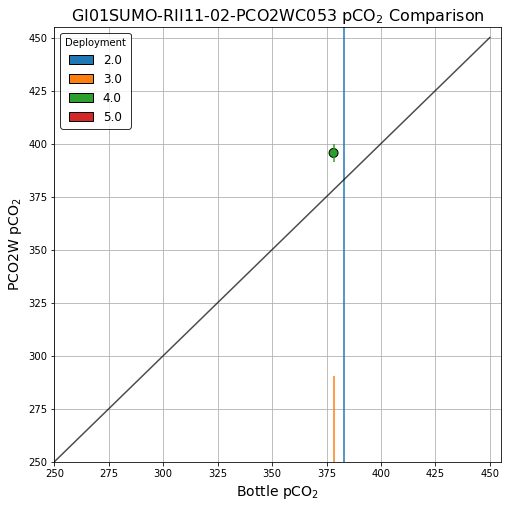

In [104]:
df = pco2w_130m_comparison.dropna(subset=["deploymentNumber"])
df["bottleCO2"] = df["bottleCO2"].astype(float)
df["CO2_avg"] = df["CO2_avg"].astype(float)
df["CO2_std"] = df["CO2_std"].astype(float)
#df = df[df["deploymentNumber"] != 3]

fig, ax = plt.subplots(figsize=(8,8))

# Set the 
levels, categories = pd.factorize(df['deploymentNumber'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data
ax.scatter(df["bottleCO2"], df["CO2_avg"], c=colors, s=80, edgecolors="black")
ax.set_xlabel(xlabel="Bottle pCO$_{2}$", fontsize=14)
ax.set_ylabel(ylabel="PCO2W pCO$_{2}$", fontsize=14)
ax.legend(handles=handles, title='Deployment', fontsize=12, edgecolor="black")
ax.grid()

# Add in vertical error bars
for i, c in enumerate(categories):
    x = df["bottleCO2"][df["deploymentNumber"] == c]
    ymin = df["CO2_avg"][df["deploymentNumber"] == c] - 2*df["CO2_std"][df["deploymentNumber"] == c]
    ymax = df["CO2_avg"][df["deploymentNumber"] == c] + 2*df["CO2_std"][df["deploymentNumber"] == c]
    ax.vlines(x, ymin, ymax, colors = plt.cm.tab10(i))

ax.set_ylim((250, 455))
ax.set_xlim((250, 455))
# Add in a 1:1 line
x = np.arange(250, 455, 5)
y = np.arange(250, 455, 5)
ax.plot(x, y, color = "black", alpha=0.7)
ax.set_title(refdes + " pCO$_{2}$ Comparison", fontsize=16)

### All PCO2Ws

In [105]:
def calculate_ylims(ds, param):
    yavg = ds[param].mean(skipna=True).values
    ystd = ds[param].std(skipna=True).values
    ymed = np.nanmedian(ds[param])
    # Need to check for way out-of-bounds values by comparison with median
    if ystd > ymed:
        yavg = ymed
        ystd = ymed*0.2
    ymin = yavg - 4*ystd
    ymax = yavg + 4*ystd
    return yavg, ystd, ymin, ymax

In [106]:
calculate_ylims(pco2w_40m, "pco2_seawater")

(array(335.16092, dtype=float32),
 array(134.49327, dtype=float32),
 -202.81216430664062,
 873.1340026855469)

Text(0.5, 0, '')

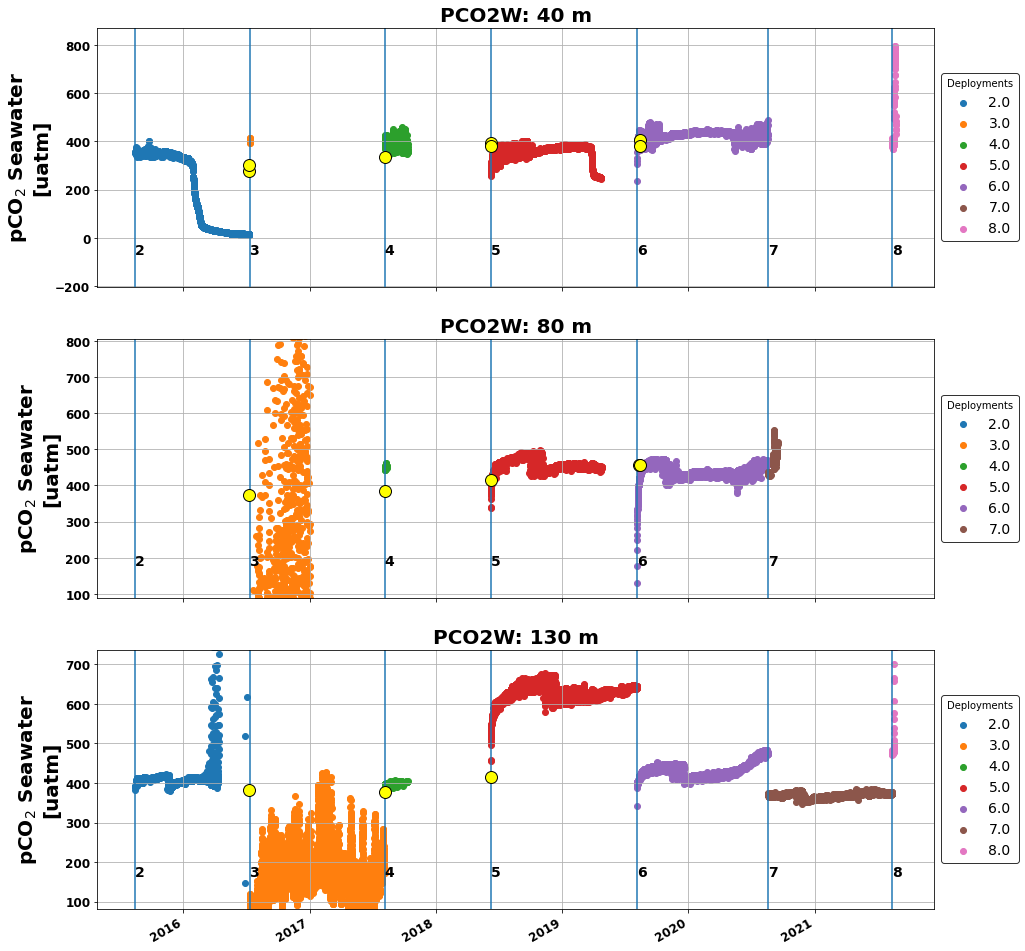

In [156]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 18), sharex=True)

param = "pco2_seawater"

# Plot the 40 m PCO2W
# -------------------
# Calculate the figure bounds
yavg, ystd, ymin, ymax = calculate_ylims(pco2w_40m, param)

# Generate the plot figure
s = pco2w_40m.plot.scatter("time", param, ax=ax[0], hue="deployment", hue_style="discrete")

# Add the deployments
ax[0].legend(edgecolor="black", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title="Deployments")
deployments = np.unique(pco2w_40m["deployment"])
for depNum in deployments:
    dt = pco2w_40m.where(pco2w_40m["deployment"] == depNum, drop=True)["time"].min()
    ax[0].vlines(dt.values, yavg-4*ystd, yavg+4*ystd)
    ax[0].text(dt.values, yavg-3*ystd, str(int(depNum)), fontsize=14, weight="bold")
xmin, xmax = ax[0].get_xlim()

# Add the bottle samples
b, = ax[0].plot(pco2w_40m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Start Time [UTC]"], 
             pco2w_40m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Calculated pCO2 [uatm]"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle\npCO$_{2}$")
#ax[0].legend(handles=[b], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)


# Set the ylims
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
ax[0].grid()
ax[0].set_title("PCO2W: 40 m", fontsize=20, weight="bold")
ax[0].set_ylabel("pCO$_{2}$ Seawater\n[uatm]", fontsize=20, weight="bold")
# Set the yticklabels
for tick in ax[0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    tick.label1.se
# Plot the 80 m PCO2W
# -------------------
# Calculate the figure bounds
yavg, ystd, ymin, ymax = calculate_ylims(pco2w_80m, param)

# Generate the plot figure
s = pco2w_80m.plot.scatter("time", param, ax=ax[1], hue="deployment", hue_style="discrete")

# Add the deployments
ax[1].legend(edgecolor="black", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title="Deployments")
deployments = np.unique(pco2w_80m["deployment"])
for depNum in deployments:
    dt = pco2w_80m.where(pco2w_80m["deployment"] == depNum, drop=True)["time"].min()
    ax[1].vlines(dt.values, yavg-4*ystd, yavg+4*ystd)
    ax[1].text(dt.values, yavg-3*ystd, str(int(depNum)), fontsize=14, weight="bold")
xmin, xmax = ax[1].get_xlim()

# Add the bottle samples
b, = ax[1].plot(pco2w_80m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Start Time [UTC]"], 
             pco2w_80m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Calculated pCO2 [uatm]"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle\npCO$_{2}$")
#ax[1].legend(handles=[b], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)


# Set the ylims
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
ax[1].grid()
ax[1].set_title("PCO2W: 80 m", fontsize=20, weight="bold")
ax[1].set_ylabel("pCO$_{2}$ Seawater\n[uatm]", fontsize=20, weight="bold")

for tick in ax[1].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
# Plot the 130 m PCO2W
# -------------------
# Calculate the figure bounds
yavg, ystd, ymin, ymax = calculate_ylims(pco2w_130m, param)

# Generate the plot figure
s = pco2w_130m.plot.scatter("time", param, ax=ax[2], hue="deployment", hue_style="discrete")

# Add the deployments
ax[2].legend(edgecolor="black", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title="Deployments")
deployments = np.unique(pco2w_130m["deployment"])
for depNum in deployments:
    dt = pco2w_130m.where(pco2w_130m["deployment"] == depNum, drop=True)["time"].min()
    ax[2].vlines(dt.values, yavg-4*ystd, yavg+4*ystd)
    ax[2].text(dt.values, yavg-3*ystd, str(int(depNum)), fontsize=14, weight="bold")
xmin, xmax = ax[2].get_xlim()

# Add the bottle samples
b, = ax[2].plot(pco2w_130m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Start Time [UTC]"], 
             pco2w_130m_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Calculated pCO2 [uatm]"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle\npCO$_{2}$")
#ax[2].legend(handles=[b], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)

ax[2].set_xlim(xmin, xmax)
# Set the ylims
ax[2].set_ylim(ymin, ymax)
ax[2].grid()
ax[2].set_title("PCO2W: 130 m", fontsize=20, weight="bold")
ax[2].set_ylabel("pCO$_{2}$ Seawater\n[uatm]", fontsize=20, weight="bold")

for tick in ax[2].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax[2].xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")


fig.autofmt_xdate()
plt.xlabel("")


In [157]:
fig.savefig("../results/all_pco2w_timeseries_with_bottle_data.png", facecolor="white", transparent=False)

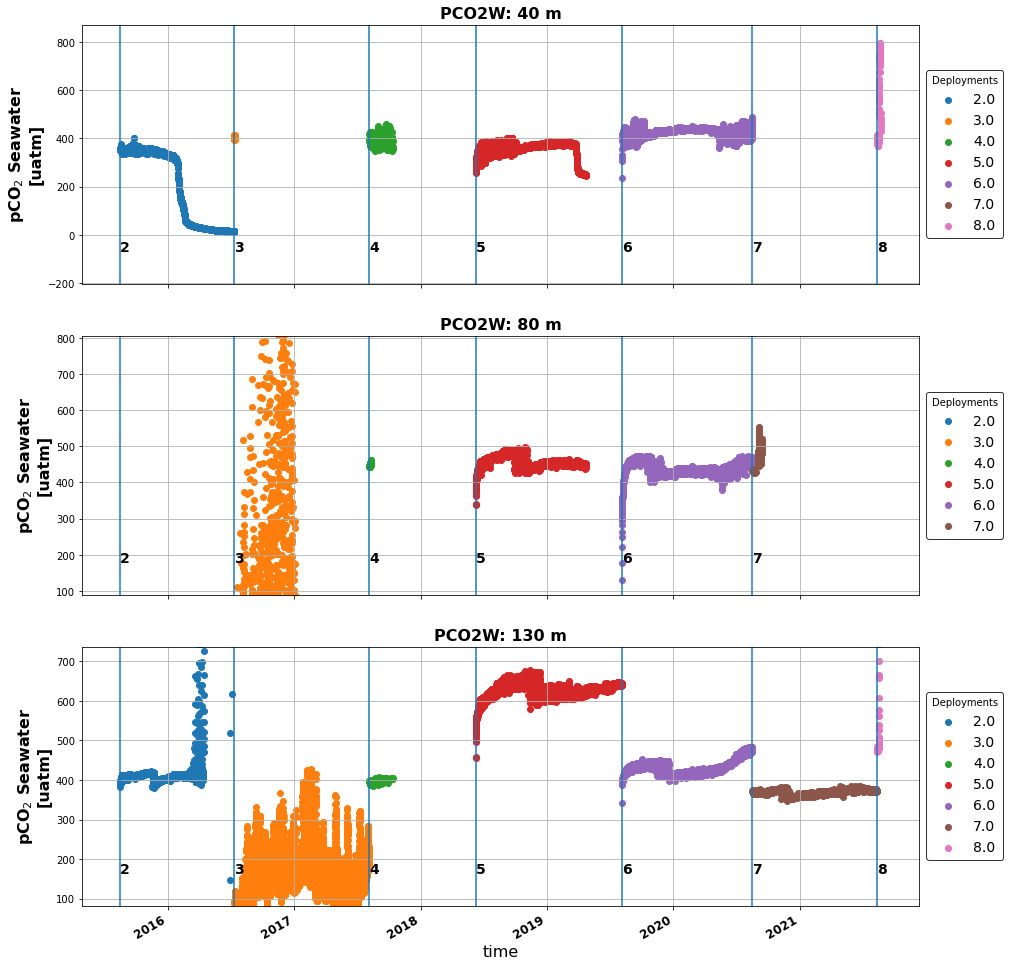

In [158]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 18), sharex=True)

param = "pco2_seawater"

# Plot the 40 m PCO2W
# -------------------
# Calculate the figure bounds
yavg, ystd, ymin, ymax = calculate_ylims(pco2w_40m, param)

# Generate the plot figure
s = pco2w_40m.plot.scatter("time", param, ax=ax[0], hue="deployment", hue_style="discrete")

# Add the deployments
ax[0].legend(edgecolor="black", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title="Deployments")
deployments = np.unique(pco2w_40m["deployment"])
for depNum in deployments:
    dt = pco2w_40m.where(pco2w_40m["deployment"] == depNum, drop=True)["time"].min()
    ax[0].vlines(dt.values, yavg-4*ystd, yavg+4*ystd)
    ax[0].text(dt.values, yavg-3*ystd, str(int(depNum)), fontsize=14, weight="bold")

# Set the ylims
ax[0].set_ylim(ymin, ymax)
ax[0].grid()
ax[0].set_title("PCO2W: 40 m", fontsize=16, weight="bold")
ax[0].set_ylabel("pCO$_{2}$ Seawater\n[uatm]", fontsize=16, weight="bold")
#plt.yticks(fontsize=12, weight="bold")


# Plot the 80 m PCO2W
# -------------------
# Calculate the figure bounds
yavg, ystd, ymin, ymax = calculate_ylims(pco2w_80m, param)

# Generate the plot figure
s = pco2w_80m.plot.scatter("time", param, ax=ax[1], hue="deployment", hue_style="discrete")

# Add the deployments
ax[1].legend(edgecolor="black", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title="Deployments")
deployments = np.unique(pco2w_80m["deployment"])
for depNum in deployments:
    dt = pco2w_80m.where(pco2w_80m["deployment"] == depNum, drop=True)["time"].min()
    ax[1].vlines(dt.values, yavg-4*ystd, yavg+4*ystd)
    ax[1].text(dt.values, yavg-3*ystd, str(int(depNum)), fontsize=14, weight="bold")

# Set the ylims
ax[1].set_ylim(ymin, ymax)
ax[1].grid()
ax[1].set_title("PCO2W: 80 m", fontsize=16, weight="bold")
ax[1].set_ylabel("pCO$_{2}$ Seawater\n[uatm]", fontsize=16, weight="bold")
#plt.yticks(fontsize=12, weight="bold")

# Plot the 130 m PCO2W
# -------------------
# Calculate the figure bounds
yavg, ystd, ymin, ymax = calculate_ylims(pco2w_130m, param)

# Generate the plot figure
s = pco2w_130m.plot.scatter("time", param, ax=ax[2], hue="deployment", hue_style="discrete")

# Add the deployments
ax[2].legend(edgecolor="black", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title="Deployments")
deployments = np.unique(pco2w_130m["deployment"])
for depNum in deployments:
    dt = pco2w_130m.where(pco2w_130m["deployment"] == depNum, drop=True)["time"].min()
    ax[2].vlines(dt.values, yavg-4*ystd, yavg+4*ystd)
    ax[2].text(dt.values, yavg-3*ystd, str(int(depNum)), fontsize=14, weight="bold")

# Set the ylims
ax[2].set_ylim(ymin, ymax)
ax[2].grid()
ax[2].set_title("PCO2W: 130 m", fontsize=16, weight="bold")
ax[2].set_ylabel("pCO$_{2}$ Seawater\n[uatm]", fontsize=16, weight="bold")
ax[2].xaxis.get_label().set_fontsize(16)
plt.xticks(fontsize=12, weight="bold")
#plt.yticks(fontsize=12, weight="bold")

fig.autofmt_xdate()

In [215]:
fig.savefig("../results/all_pco2w_timeseries.png", facecolor="white", transparent=False)

In [137]:
pco2w_40m.attrs

{'node': 'RII11',
 'comment': 'Data collected from the OOI M2M API and reworked for use in locally stored NetCDF files.',
 'publisher_email': '',
 'sourceUrl': 'http://oceanobservatories.org/',
 'collection_method': 'recovered_inst',
 'stream': 'pco2w_abc_instrument',
 'featureType': 'timeSeries',
 'creator_email': '',
 'publisher_name': 'Ocean Observatories Initiative',
 'date_modified': '2021-07-26T03:15:38.006137',
 'keywords': '',
 'cdm_data_type': 'Station',
 'references': 'More information can be found at http://oceanobservatories.org/',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'date_created': '2021-07-26T03:15:38.006135',
 'id': 'GI01SUMO-RII11-02-PCO2WC051-recovered_inst-pco2w_abc_instrument',
 'requestUUID': 'ef47531a-6d19-41dd-810e-a7528ec5c8f3',
 'contributor_role': '',
 'summary': 'Dataset Generated by Stream Engine from Ocean Observatories Initiative',
 'keywords_vocabulary': '',
 'institution': 'Ocean Observatories Initiative',
 'naming_authority': 'org

In [159]:
pco2w_40m_comparison["instrument"] = "40m"
pco2w_80m_comparison["instrument"] = "80m"
pco2w_130m_comparison["instrument"] = "130m"

pco2w_comparison = pco2w_40m_comparison.append(pco2w_80m_comparison).append(pco2w_130m_comparison)
pco2w_comparison.to_excel("../results/PCO2W_comparison.xlsx", index=False)

Plot the comparison of data, dropping the NaN

In [160]:
import seaborn as sns
import matplotlib.patches

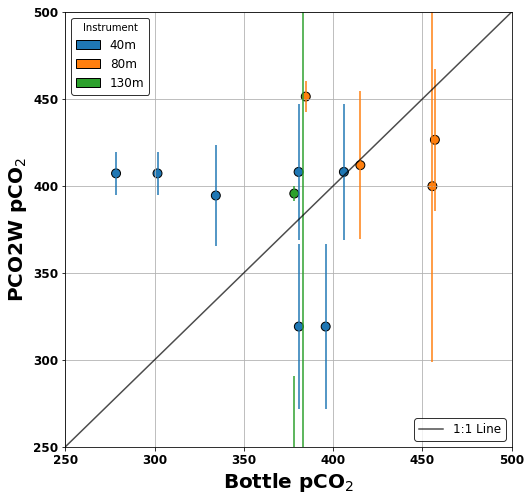

In [249]:
df = pco2w_comparison.dropna(subset=["deploymentNumber"])
df["bottleCO2"] = df["bottleCO2"].astype(float)
df["CO2_avg"] = df["CO2_avg"].astype(float)
df["CO2_std"] = df["CO2_std"].astype(float)
#df = df[df["deploymentNumber"] != 3]

fig, ax = plt.subplots(figsize=(8,8))

# Set the 
levels, categories = pd.factorize(df['instrument'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data
ax.scatter(df["bottleCO2"], df["CO2_avg"], c=colors, s=80, edgecolors="black")
ax.set_xlabel(xlabel="Bottle pCO$_{2}$", fontsize=20, weight="bold")
ax.set_ylabel(ylabel="PCO2W pCO$_{2}$", fontsize=20, weight="bold")
ax.legend(handles=handles, title='Instrument', fontsize=12, edgecolor="black")
ax.grid()

first_legend = ax.get_legend()
ax.add_artist(first_legend)

# Add in vertical error bars
for i, c in enumerate(categories):
    x = df["bottleCO2"][df["instrument"] == c]
    ymin = df["CO2_avg"][df["instrument"] == c] - 2*df["CO2_std"][df["instrument"] == c]
    ymax = df["CO2_avg"][df["instrument"] == c] + 2*df["CO2_std"][df["instrument"] == c]
    ax.vlines(x, ymin, ymax, colors = plt.cm.tab10(i))

ax.set_ylim((250, 500))
ax.set_xlim((250, 500))
# Add in a 1:1 line
x = np.arange(200, 505, 5)
y = np.arange(200, 505, 5)
s, = ax.plot(x, y, color = "black", alpha=0.7, label="1:1 Line")
ax.legend(handles=[s], edgecolor="black", loc="lower right", fontsize=12)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
#ax.legend(handles=[s], edgecolor="black", loc="lower right", fontsize=12)

In [171]:
fig.savefig("../results/pco2w_comparison.png", facecolor="white", transparent=False)

### PHSEN 20 m

In [172]:
from OS2022.OS2022 import process_phsen

Text(0.5, 1.0, 'GI01SUMO-RII11-02-PHSENE041')

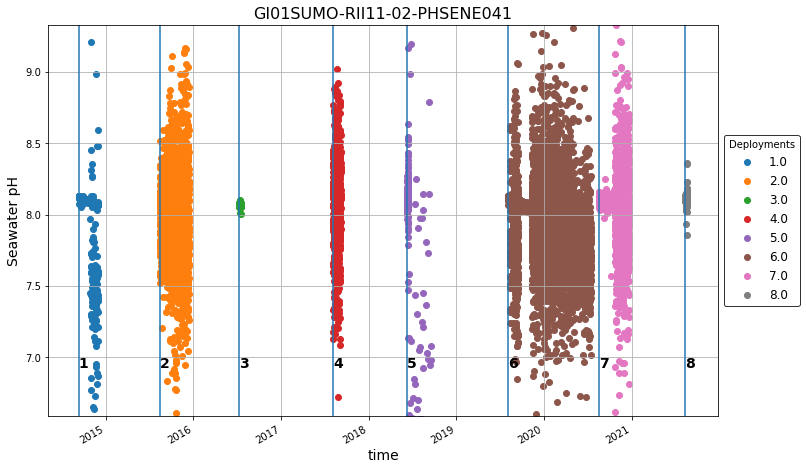

In [173]:
refdes = "GI01SUMO-RII11-02-PHSENE041"

phsen_20m = xr.open_dataset("../data/GI01SUMO-RII11-02-PHSENE041_combined.nc", chunks="auto")

annotations = OOINet.get_annotations("GI01SUMO-RII11-02-PHSENE041")

phsen_20m = OOINet.add_annotation_qc_flag(phsen_20m, annotations)

#phsen_20m = phsen_20m.where(phsen_20m.rollup_annotations_qc_results != 9, drop=True)

fig, ax = plotting.plot_variable(phsen_20m, "seawater_ph")
ax.set_title(refdes, fontsize=16)

In [174]:
if not os.path.exists(f"../results/{refdes}"):
    os.makedirs(f"../results/{refdes}")
    
fig.savefig(f"../results/{refdes}/time_series.png")

#### CTD Data

In [175]:
ctdmo_20m = xr.open_dataset("../data/GI01SUMO-RII11-02-CTDMOQ011_combined.nc", chunks="auto")

seawater_temperature = ctdmo_20m["ctdmo_seawater_temperature"].interp_like(phsen_20m)
seawater_pressure = ctdmo_20m["ctdmo_seawater_pressure"].interp_like(phsen_20m)

# Add to the pco2w
phsen_20m["seawater_temperature"] = seawater_temperature
phsen_20m["seawater_pressure"] = seawater_pressure

#### Quality Checks
Next, add in the quality checks for the data

In [176]:
qc_flags = process_phsen.quality_checks(phsen_20m)
phsen_20m["qc_flags"] = qc_flags

Text(0.5, 1.0, 'GI01SUMO-RII11-02-PHSENE041')

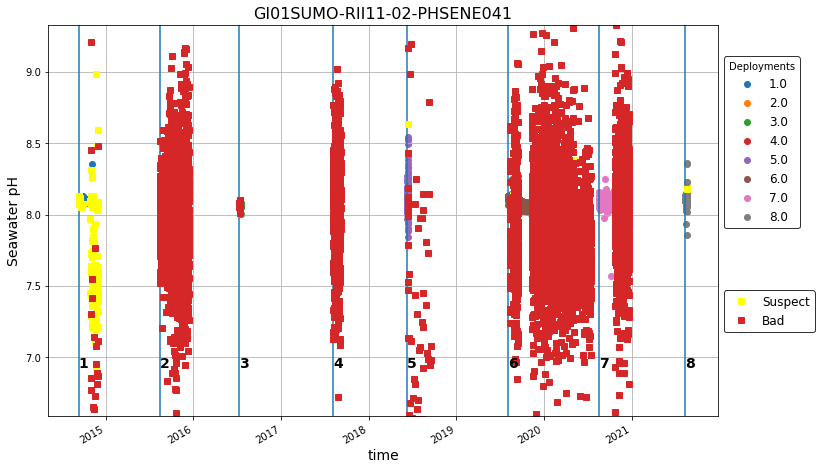

In [177]:
fig, ax = plotting.plot_variable(phsen_20m, "seawater_ph")

# Plot figure which highlights data points with a corresponding annotation
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s1, = ax.plot(phsen_20m.time.where(phsen_20m.qc_flags == 3), 
             phsen_20m.seawater_ph.where(phsen_20m.qc_flags == 3), 
             marker="s", linestyle="", color="yellow", label="Suspect")
s2, = ax.plot(phsen_20m.time.where(phsen_20m.qc_flags == 4), 
             phsen_20m.seawater_ph.where(phsen_20m.qc_flags == 4), 
             marker="s", linestyle="", color="tab:red", label="Bad")

ax.legend(handles=[s1, s2], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_title(refdes, fontsize=16)

In [178]:
if not os.path.exists(f"../results/{refdes}"):
    os.makedirs(f"../results/{refdes}")
    
fig.savefig(f"../results/{refdes}/time_series.png")

In [179]:
# Drop the bad data
phsen_20m = phsen_20m.where(phsen_20m.qc_flags != 4, drop=True)

In [180]:
deployments = OOINet.get_deployments(refdes)

lat, lon, depth = deployments["latitude"].mean(), deployments["longitude"].mean(), deployments["depth"].mean()

lat, lon, depth

(59.939533, -39.52212087499999, 20.0)

In [181]:
phsen_20m_bottles = findSamples(carbonData, (lat, lon), depth, 5, 20)
phsen_20m_bottles

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pCO2 [lab conditions],Calculated pH [lab conditions]
10,AR35-05,9,"GI01SUMO, GI02HYPM",59.965767,-39.565850,2019-08-11 16:43:00+00:00,9,*0000000000000001,2654.0,NaN,...,NaN,145.738071,NaN,NaN,34.770743,10.286703,1026.652053,1026.652053,720.162701,7.831473
43,AR35-05,11,"GI01SUMO, GI02HYPM, Gliders",59.968500,-39.578500,2019-08-15 09:06:49+00:00,11,*0000000000000101,2650.0,D:\Data\ar35-05011.hex,...,NaN,146.777619,NaN,NaN,34.810980,10.287590,1026.723683,1026.723683,714.057296,7.834860
44,AR35-05,11,"GI01SUMO, GI02HYPM, Gliders",59.968500,-39.578500,2019-08-15 09:06:49+00:00,11,*0000000000000101,2650.0,D:\Data\ar35-05011.hex,...,NaN,146.428431,NaN,NaN,34.810774,10.274055,1026.686945,1026.686945,715.993229,7.833760
47,AR35-05,11,"GI01SUMO, GI02HYPM, Gliders",59.968500,-39.578500,2019-08-15 09:06:49+00:00,11,*0000000000000101,2650.0,D:\Data\ar35-05011.hex,...,NaN,148.282029,NaN,NaN,34.811008,10.292748,1026.651219,1026.651219,705.262325,7.839594
114,AR7-01,6,SUMO,59.933167,-39.450833,2016-07-10 19:49:21+00:00,6,*0000000000000100,2724.0,D:\Data\ar0701006.hex,...,NaN,163.105096,NaN,NaN,35.020167,8.022518,1027.252648,1027.252648,633.497896,7.883701
115,AR7-01,6,SUMO,59.933167,-39.450833,2016-07-10 19:49:21+00:00,6,*0000000000000100,2724.0,D:\Data\ar0701006.hex,...,NaN,163.282139,NaN,NaN,35.017051,8.417905,1027.159284,1027.159284,633.948229,7.883440
185,AR21,7,SUMO,59.926333,-39.516167,2017-08-05 20:24:20+00:00,7,*0000000000000100,2711.0,D:\Data\AR21_007.hex,...,NaN,152.223015,NaN,NaN,34.949548,8.302538,1027.170001,1027.170001,690.445722,7.850764
186,AR21,7,SUMO,59.926333,-39.516167,2017-08-05 20:24:20+00:00,7,*0000000000000100,2711.0,D:\Data\AR21_007.hex,...,NaN,155.280405,NaN,NaN,34.953656,8.455740,1027.112061,1027.112061,673.784394,7.860045
187,AR21,7,SUMO,59.926333,-39.516167,2017-08-05 20:24:20+00:00,7,*0000000000000100,2711.0,D:\Data\AR21_007.hex,...,NaN,157.047274,NaN,NaN,34.955449,8.496928,1027.048524,1027.048524,666.461253,7.864683
325,KN221-04,5,GI01SUMO,59.924167,-39.509333,2014-09-11 22:48:32+00:00,5,*0000000000000100,2714.0,C:\Data\ctd\KN22104005.hex,...,NaN,146.321208,NaN,NaN,34.937910,9.185501,1026.979217,1026.979217,714.771183,7.834307


Text(0.5, 1.0, 'GI01SUMO-RII11-02-PHSENE041')

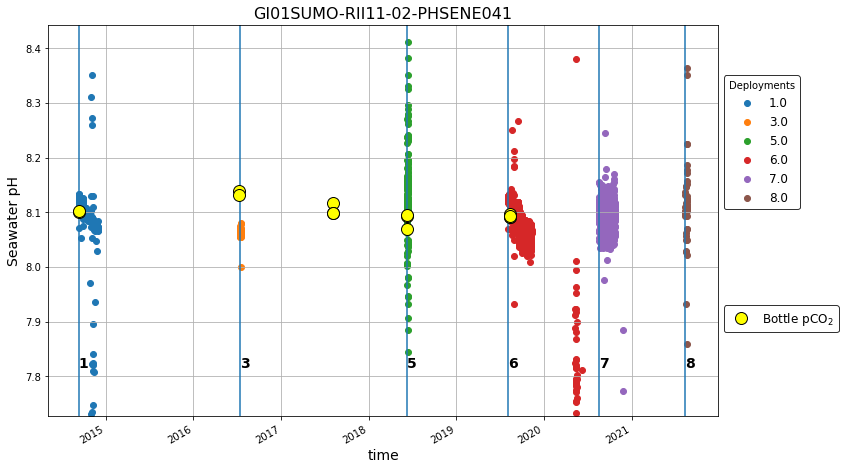

In [182]:
fig, ax = plotting.plot_variable(phsen_20m, "seawater_ph")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

s, = ax.plot(phsen_20m_bottles.dropna(subset=["Calculated pH"])["Start Time [UTC]"], 
             phsen_20m_bottles.dropna(subset=["Calculated pH"])["Calculated pH"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle pCO$_{2}$")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_xlim(xmin, xmax)
ax.set_title(refdes, fontsize=16)

In [183]:
if not os.path.exists(f"../results/{refdes}/"):
    os.makedirs(f"../results/{refdes}/")
    
fig.savefig(f"../results/{refdes}/time_series_with_discrete_bottles")

In [184]:
phsen_20m_comparison = pd.DataFrame(columns=["deploymentNumber", "time", "PH_avg", "PH_std", "T", "S", "P",
                                            "bottlePH", "bottleT", "bottleS", "bottleP"])

for ind in phsen_20m_bottles.index:
    # Get the time stamps of a bottle
    t = phsen_20m_bottles["Start Time [UTC]"].loc[ind]
    t = t.tz_localize(None)

    # Get the bottle pCO2a
    bottlePH = phsen_20m_bottles["Calculated pH"].loc[ind]
    bottleT = phsen_20m_bottles[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].loc[ind].mean(skipna=True)
    bottleS = phsen_20m_bottles[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].loc[ind].mean(skipna=True)
    bottleP = phsen_20m_bottles["CTD Pressure [db]"].loc[ind]

    # Create a time window to look for data
    dt = pd.Timedelta(days=7)
    tmin = t - dt
    tmax = t + dt

    # Find the data within the time series
    subset = phsen_20m.where((phsen_20m.time >= tmin) & (phsen_20m.time <= tmax), drop=True)
    # Check for unique deployments
    deps = np.unique(subset.deployment)
    # If more than one deployment, split it based on deployments
    if len(deps) > 1:
        for depNum in deps:
            dep_subset = subset.where(subset.deployment == depNum, drop=True)
            pco2_avg = dep_subset.seawater_ph.mean(skipna=True).compute().values
            pco2_std = dep_subset.seawater_ph.std(skipna=True).compute().values
            pco2_temp = dep_subset.seawater_temperature.mean().compute().values
            pco2_sal = dep_subset.practical_salinity.mean().compute().values
            pco2_pres = dep_subset.seawater_pressure.mean().compute().values
            phsen_20m_comparison = phsen_20m_comparison.append({
                    "deploymentNumber": depNum,
                    "time": t,
                    "PH_avg": pco2_avg,
                    "PH_std": pco2_std,
                    "T": pco2_temp,
                    "S": pco2_sal,
                    "P": pco2_pres,
                    "bottlePH": bottlePH,
                    "bottleT": bottleT,
                    "bottleS": bottleS,
                    "bottleP": bottleP,
                }, ignore_index=True)
    elif len(deps) == 1:
        pco2_avg = subset.seawater_ph.mean(skipna=True).compute().values
        pco2_std = subset.seawater_ph.std(skipna=True).compute().values
        pco2_temp = subset.seawater_temperature.mean().compute().values
        pco2_sal = subset.practical_salinity.mean().compute().values
        pco2_pres = subset.seawater_pressure.mean().compute().values
        depNum = deps[0]
        phsen_20m_comparison = phsen_20m_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "PH_avg": pco2_avg,
                "PH_std": pco2_std,
                "T": pco2_temp,
                "S": pco2_sal,
                "P": pco2_pres,
                "bottlePH": bottlePH,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)
    else:
        # Now put in NaNs for the missing results data
        phsen_20m_comparison = phsen_20m_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "PH_avg": None,
                "PH_std": None,
                "T": None,
                "S": None,
                "P": None,
                "bottlePH": bottlePH,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)

# Save the results
phsen_20m_comparison

,deploymentNumber,time,PH_avg,PH_std,T,S,P,bottlePH,bottleT,bottleS,bottleP
0,6.0,2019-08-11 16:43:00,8.119508908244518,0.007954397023096938,10.06711810184279,34.645788621289,18.786228600850656,8.096222,10.29100,34.60600,12.000
1,6.0,2019-08-15 09:06:49,8.117501410533148,0.011503983385373177,10.222709236138904,34.64836912015561,18.753554083012002,8.090853,10.29370,34.64625,21.040
2,6.0,2019-08-15 09:06:49,8.117501410533148,0.011503983385373177,10.222709236138904,34.64836912015561,18.753554083012002,8.090704,10.27915,34.64585,12.390
3,6.0,2019-08-15 09:06:49,8.117501410533148,0.011503983385373177,10.222709236138904,34.64836912015561,18.753554083012002,8.093376,10.29700,34.64600,5.132
4,3.0,2016-07-10 19:49:21,8.062805969798243,0.005185541924286493,8.372283093483054,34.83739461618634,19.961370742836433,8.139717,8.03135,34.85445,20.887
5,3.0,2016-07-10 19:49:21,8.062805969798243,0.005185541924286493,8.372283093483054,34.83739461618634,19.961370742836433,8.132172,8.42625,34.85120,14.150
6,3.0,2017-08-05 20:24:20,None,None,None,None,None,8.116870,8.31075,34.78415,24.163
7,3.0,2017-08-05 20:24:20,None,None,None,None,None,8.098841,8.46325,34.78815,15.900
8,3.0,2017-08-05 20:24:20,None,None,None,None,None,8.099234,8.50315,34.78975,3.003
9,1.0,2014-09-11 22:48:32,8.114444541284838,0.010668487832826704,8.59860061844782,34.8022115635315,20.666368690241946,8.100194,9.19295,34.77245,14.837


In [185]:
import matplotlib

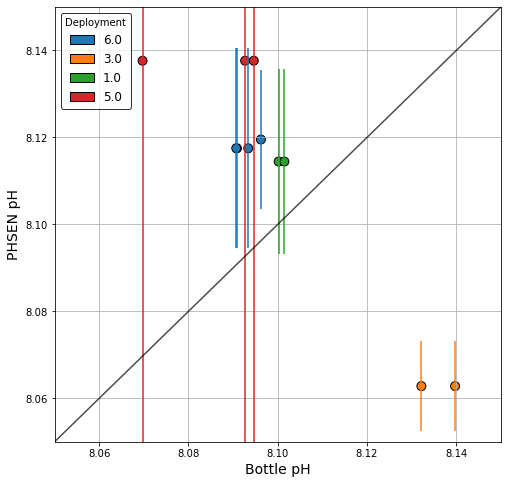

In [186]:
df = phsen_20m_comparison.dropna(subset=["deploymentNumber"])
df["bottlePH"] = df["bottlePH"].astype(float)
df["PH_avg"] = df["PH_avg"].astype(float)
df["PH_std"] = df["PH_std"].astype(float)
#df = df[df["deploymentNumber"] != 3]

fig, ax = plt.subplots(figsize=(8,8))

# Set the 
levels, categories = pd.factorize(df['deploymentNumber'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data
ax.scatter(df["bottlePH"], df["PH_avg"], c=colors, s=80, edgecolors="black")
ax.set_xlabel(xlabel="Bottle pH", fontsize=14)
ax.set_ylabel(ylabel="PHSEN pH", fontsize=14)
ax.legend(handles=handles, title='Deployment', fontsize=12, edgecolor="black")
ax.grid()

# Add in vertical error bars
for i, c in enumerate(categories):
    x = df["bottlePH"][df["deploymentNumber"] == c]
    ymin = df["PH_avg"][df["deploymentNumber"] == c] - 2*df["PH_std"][df["deploymentNumber"] == c]
    ymax = df["PH_avg"][df["deploymentNumber"] == c] + 2*df["PH_std"][df["deploymentNumber"] == c]
    ax.vlines(x, ymin, ymax, colors = plt.cm.tab10(i))

ax.set_ylim((8.05, 8.15))
ax.set_xlim((8.05, 8.15))
# Add in a 1:1 line
x = np.arange(8, 8.205, 0.05)
y = np.arange(8, 8.205, 0.05)
ax.plot(x, y, color = "black", alpha=0.7)

In [187]:
fig.savefig(f"../results/{refdes}/instrument_vs_bottle_comparison.png")

### PHSEN SUMO 100m

Text(0.5, 1.0, 'GI01SUMO-RII11-02-PHSENE042')

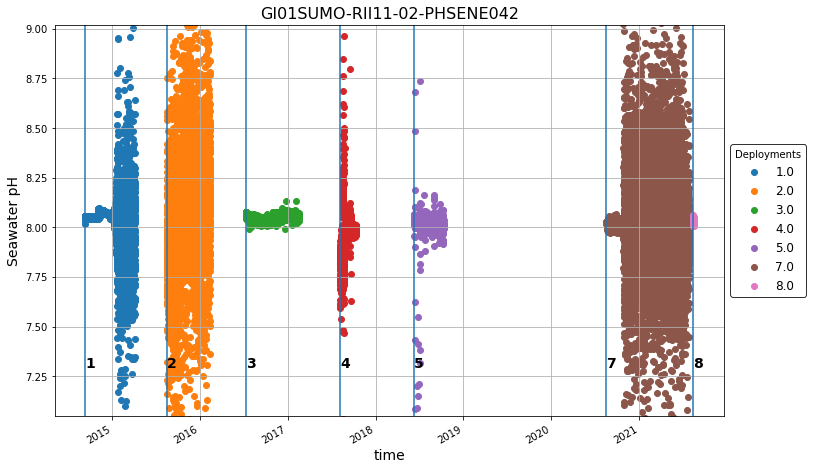

In [188]:
refdes = "GI01SUMO-RII11-02-PHSENE042"

phsen_100m = xr.open_dataset("../data/GI01SUMO-RII11-02-PHSENE042_combined.nc", chunks="auto")

annotations = OOINet.get_annotations("GI01SUMO-RII11-02-PHSENE042")

phsen_100m = OOINet.add_annotation_qc_flag(phsen_100m, annotations)

#phsen_100m = phsen_100m.where(phsen_100m.rollup_annotations_qc_results != 9, drop=True)

fig, ax = plotting.plot_variable(phsen_100m, "seawater_ph")
ax.set_title(refdes, fontsize=16)

In [189]:
if not os.path.exists(f"../results/{refdes}"):
    os.makedirs(f"../results/{refdes}")
    
fig.savefig(f"../results/{refdes}/time_series.png")

#### CTD Data

In [190]:
ctdmo_100m = xr.open_dataset("../data/GI01SUMO-RII11-02-CTDMOQ013_combined.nc", chunks="auto")

seawater_temperature = ctdmo_100m["ctdmo_seawater_temperature"].interp_like(phsen_100m)
seawater_pressure = ctdmo_100m["ctdmo_seawater_pressure"].interp_like(phsen_100m)

# Add to the pco2w
phsen_100m["seawater_temperature"] = seawater_temperature
phsen_100m["seawater_pressure"] = seawater_pressure

#### Quality Checks
Next, add in the quality checks for the data

In [191]:
qc_flags = process_phsen.quality_checks(phsen_100m)
phsen_100m["qc_flags"] = qc_flags

Text(0.5, 1.0, 'GI01SUMO-RII11-02-PHSENE042')

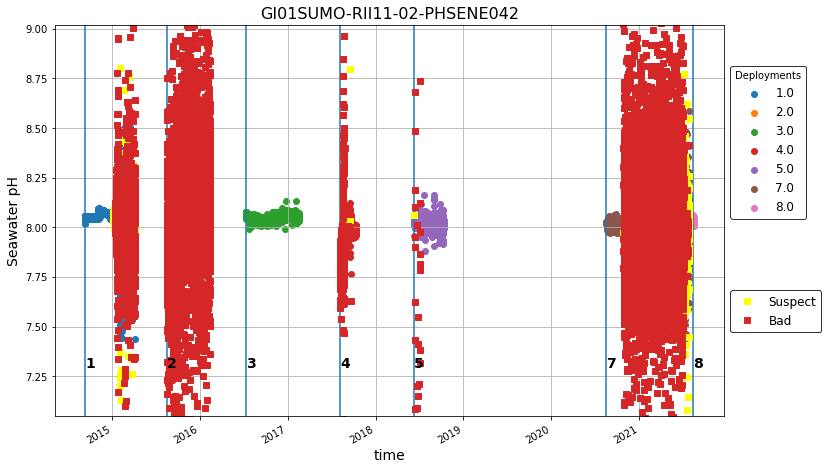

In [192]:
fig, ax = plotting.plot_variable(phsen_100m, "seawater_ph")

# Plot figure which highlights data points with a corresponding annotation
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s1, = ax.plot(phsen_100m.time.where(phsen_100m.qc_flags == 3), 
             phsen_100m.seawater_ph.where(phsen_100m.qc_flags == 3), 
             marker="s", linestyle="", color="yellow", label="Suspect")
s2, = ax.plot(phsen_100m.time.where(phsen_100m.qc_flags == 4), 
             phsen_100m.seawater_ph.where(phsen_100m.qc_flags == 4), 
             marker="s", linestyle="", color="tab:red", label="Bad")

ax.legend(handles=[s1, s2], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_title(refdes, fontsize=16)

In [193]:
if not os.path.exists(f"../results/{refdes}"):
    os.makedirs(f"../results/{refdes}")
    
fig.savefig(f"../results/{refdes}/time_series.png")

In [194]:
# Drop the bad data
phsen_100m = phsen_100m.where(phsen_100m.qc_flags != 4, drop=True)

In [195]:
deployments = OOINet.get_deployments(refdes)

lat, lon, depth = deployments["latitude"].mean(), deployments["longitude"].mean(), deployments["depth"].mean()

In [196]:
phsen_100m_bottles = findSamples(carbonData, (lat, lon), depth, 5, 20)
phsen_100m_bottles

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pCO2 [lab conditions],Calculated pH [lab conditions]
7,AR35-05,9,"GI01SUMO, GI02HYPM",59.965767,-39.565850,2019-08-11 16:43:00+00:00,9,*0000000000000001,2654.0,NaN,...,NaN,102.485338,NaN,NaN,34.952131,4.970966,1027.885044,1027.885044,1080.159003,7.676956
38,AR35-05,11,"GI01SUMO, GI02HYPM, Gliders",59.968500,-39.578500,2019-08-15 09:06:49+00:00,11,*0000000000000101,2650.0,D:\Data\ar35-05011.hex,...,NaN,102.034894,NaN,NaN,34.983098,4.755136,1028.030716,1028.030716,1087.243086,7.674860
40,AR35-05,11,"GI01SUMO, GI02HYPM, Gliders",59.968500,-39.578500,2019-08-15 09:06:49+00:00,11,*0000000000000101,2650.0,D:\Data\ar35-05011.hex,...,NaN,102.010500,NaN,NaN,34.949625,4.917004,1027.893495,1027.893495,1085.936131,7.674937
110,AR7-01,6,SUMO,59.933167,-39.450833,2016-07-10 19:49:21+00:00,6,*0000000000000100,2724.0,D:\Data\ar0701006.hex,...,NaN,114.926347,NaN,NaN,35.123467,4.440292,1028.178923,1028.178923,967.330744,7.723665
112,AR7-01,6,SUMO,59.933167,-39.450833,2016-07-10 19:49:21+00:00,6,*0000000000000100,2724.0,D:\Data\ar0701006.hex,...,NaN,119.839544,NaN,NaN,35.102596,4.419188,1028.066005,1028.066005,919.572784,7.743121
182,AR21,7,SUMO,59.926333,-39.516167,2017-08-05 20:24:20+00:00,7,*0000000000000100,2711.0,D:\Data\AR21_007.hex,...,NaN,123.468395,NaN,NaN,35.096797,4.662695,1028.143647,1028.143647,891.607476,7.755478
184,AR21,7,SUMO,59.926333,-39.516167,2017-08-05 20:24:20+00:00,7,*0000000000000100,2711.0,D:\Data\AR21_007.hex,...,NaN,118.958320,NaN,NaN,35.090857,4.823939,1028.023036,1028.023036,929.434357,7.738829
321,KN221-04,5,GI01SUMO,59.924167,-39.509333,2014-09-11 22:48:32+00:00,5,*0000000000000100,2714.0,C:\Data\ctd\KN22104005.hex,...,NaN,108.721263,NaN,NaN,35.109806,5.006168,1028.107521,1028.107521,1017.080060,7.701072
594,AR30-03,5,SUMO,59.940500,-39.523000,2018-06-08 18:14:14+00:00,5,*0000000000000100,2702.0,D:\Data\ar30-03005.hex,...,NaN,108.709413,NaN,NaN,35.043485,4.748965,1028.078463,1028.078463,1014.403217,7.702217
596,AR30-03,5,SUMO,59.940500,-39.523000,2018-06-08 18:14:14+00:00,5,*0000000000000100,2702.0,D:\Data\ar30-03005.hex,...,NaN,112.072733,NaN,NaN,35.080798,5.156514,1027.967184,1027.967184,982.440955,7.714562


Text(0.5, 1.0, 'GI01SUMO-RII11-02-PHSENE042')

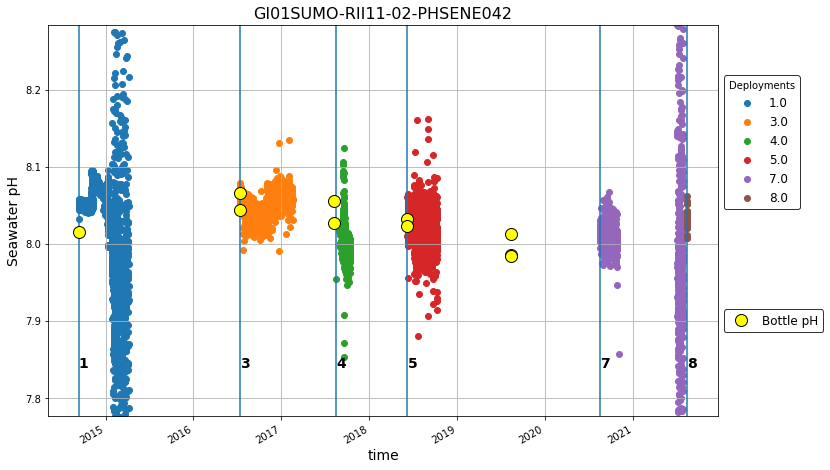

In [197]:
fig, ax = plotting.plot_variable(phsen_100m, "seawater_ph")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

s, = ax.plot(phsen_100m_bottles.dropna(subset=["Calculated pH"])["Start Time [UTC]"], 
             phsen_100m_bottles.dropna(subset=["Calculated pH"])["Calculated pH"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle pH")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_xlim(xmin, xmax)
ax.set_title(refdes, fontsize=16)

In [198]:
if not os.path.exists(f"../results/{refdes}"):
    os.makedirs(f"../results/{refdes}")
    
fig.savefig(f"../results/{refdes}/time_series_with_discrete_bottles.png")

In [199]:
phsen_100m_comparison = pd.DataFrame(columns=["deploymentNumber", "time", "PH_avg", "PH_std", "T", "S", "P",
                                            "bottlePH", "bottleT", "bottleS", "bottleP"])

for ind in phsen_100m_bottles.index:
    # Get the time stamps of a bottle
    t = phsen_100m_bottles["Start Time [UTC]"].loc[ind]
    t = t.tz_localize(None)

    # Get the bottle pCO2a
    bottlePH = phsen_100m_bottles["Calculated pH"].loc[ind]
    bottleT = phsen_100m_bottles[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].loc[ind].mean(skipna=True)
    bottleS = phsen_100m_bottles[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].loc[ind].mean(skipna=True)
    bottleP = phsen_100m_bottles["CTD Pressure [db]"].loc[ind]

    # Create a time window to look for data
    dt = pd.Timedelta(days=7)
    tmin = t - dt
    tmax = t + dt

    # Find the data within the time series
    subset = phsen_100m.where((phsen_100m.time >= tmin) & (phsen_100m.time <= tmax), drop=True)
    # Check for unique deployments
    deps = np.unique(subset.deployment)
    # If more than one deployment, split it based on deployments
    if len(deps) > 1:
        for depNum in deps:
            dep_subset = subset.where(subset.deployment == depNum, drop=True)
            pco2_avg = dep_subset.seawater_ph.mean(skipna=True).compute().values
            pco2_std = dep_subset.seawater_ph.std(skipna=True).compute().values
            pco2_temp = dep_subset.seawater_temperature.mean().compute().values
            pco2_sal = dep_subset.practical_salinity.mean().compute().values
            pco2_pres = dep_subset.seawater_pressure.mean().compute().values
            phsen_100m_comparison = phsen_100m_comparison.append({
                    "deploymentNumber": depNum,
                    "time": t,
                    "PH_avg": pco2_avg,
                    "PH_std": pco2_std,
                    "T": pco2_temp,
                    "S": pco2_sal,
                    "P": pco2_pres,
                    "bottlePH": bottlePH,
                    "bottleT": bottleT,
                    "bottleS": bottleS,
                    "bottleP": bottleP,
                }, ignore_index=True)
    elif len(deps) == 1:
        pco2_avg = subset.seawater_ph.mean(skipna=True).compute().values
        pco2_std = subset.seawater_ph.std(skipna=True).compute().values
        pco2_temp = subset.seawater_temperature.mean().compute().values
        pco2_sal = subset.practical_salinity.mean().compute().values
        pco2_pres = subset.seawater_pressure.mean().compute().values
        depNum = deps[0]
        phsen_100m_comparison = phsen_100m_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "PH_avg": pco2_avg,
                "PH_std": pco2_std,
                "T": pco2_temp,
                "S": pco2_sal,
                "P": pco2_pres,
                "bottlePH": bottlePH,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)
    else:
        # Now put in NaNs for the missing results data
        phsen_100m_comparison = phsen_100m_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "PH_avg": None,
                "PH_std": None,
                "T": None,
                "S": None,
                "P": None,
                "bottlePH": bottlePH,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)

# Save the results
phsen_100m_comparison

,deploymentNumber,time,PH_avg,PH_std,T,S,P,bottlePH,bottleT,bottleS,bottleP
0,5.0,2019-08-11 16:43:00,None,None,None,None,None,7.985622,4.98100,34.78600,81.000
1,5.0,2019-08-15 09:06:49,None,None,None,None,None,8.012366,4.76680,34.81670,101.794
2,5.0,2019-08-15 09:06:49,None,None,None,None,None,7.984291,4.92700,34.78350,81.883
3,3.0,2016-07-10 19:49:21,8.05828969371643,0.008081062913054451,3.5881858295391207,35.539801069590816,99.89622407498693,8.044388,4.45300,34.95640,102.137
4,3.0,2016-07-10 19:49:21,8.05828969371643,0.008081062913054451,3.5881858295391207,35.539801069590816,99.89622407498693,8.066452,4.43005,34.93575,80.786
5,3.0,2017-08-05 20:24:20,None,None,None,None,None,8.026863,4.67570,34.92985,104.540
6,3.0,2017-08-05 20:24:20,None,None,None,None,None,8.054889,4.83555,34.92405,83.499
7,1.0,2014-09-11 22:48:32,8.052200251254176,0.0037223009417745104,4.721024186803625,34.92038695807762,100.63424362590288,8.014677,5.01985,34.94280,103.228
8,5.0,2018-06-08 18:14:14,8.031444451794908,0.01596599149995705,5.168864719154192,34.89086784876347,99.97383347957255,8.031837,4.76130,34.87680,101.681
9,5.0,2018-06-08 18:14:14,8.031444451794908,0.01596599149995705,5.168864719154192,34.89086784876347,99.97383347957255,8.023179,5.16840,34.91405,81.656


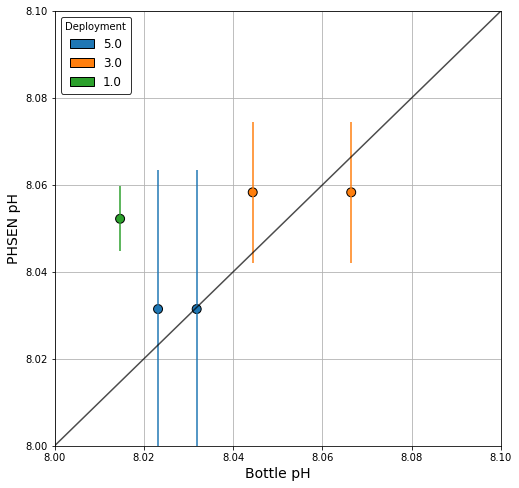

In [200]:
df = phsen_100m_comparison.dropna(subset=["deploymentNumber"])
df["bottlePH"] = df["bottlePH"].astype(float)
df["PH_avg"] = df["PH_avg"].astype(float)
df["PH_std"] = df["PH_std"].astype(float)
#df = df[df["deploymentNumber"] != 3]

fig, ax = plt.subplots(figsize=(8,8))

# Set the 
levels, categories = pd.factorize(df['deploymentNumber'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data
ax.scatter(df["bottlePH"], df["PH_avg"], c=colors, s=80, edgecolors="black")
ax.set_xlabel(xlabel="Bottle pH", fontsize=14)
ax.set_ylabel(ylabel="PHSEN pH", fontsize=14)
ax.legend(handles=handles, title='Deployment', fontsize=12, edgecolor="black")
ax.grid()

# Add in vertical error bars
for i, c in enumerate(categories):
    x = df["bottlePH"][df["deploymentNumber"] == c]
    ymin = df["PH_avg"][df["deploymentNumber"] == c] - 2*df["PH_std"][df["deploymentNumber"] == c]
    ymax = df["PH_avg"][df["deploymentNumber"] == c] + 2*df["PH_std"][df["deploymentNumber"] == c]
    ax.vlines(x, ymin, ymax, colors = plt.cm.tab10(i))

ax.set_ylim((8, 8.10))
ax.set_xlim((8, 8.10))
# Add in a 1:1 line
x = np.arange(8, 8.2, 0.05)
y = np.arange(8, 8.2, 0.05)
ax.plot(x, y, color = "black", alpha=0.7)

In [201]:
fig.savefig(f"../results/{refdes}/instrument_vs_bottle_comparison.png")

### FLMA PHSEN

In [202]:
import process_pco2w, process_phsen

Text(0.5, 1.0, 'GI03FLMA-RIS01-04-PHSENF000')

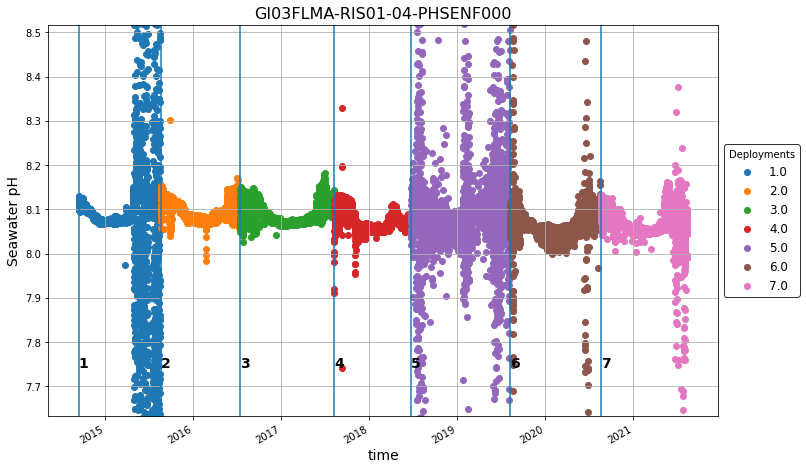

In [203]:
refdes = "GI03FLMA-RIS01-04-PHSENF000"

phsen_flma = xr.open_dataset("../data/GI03FLMA-RIS01-04-PHSENF000_combined.nc", chunks="auto")
#phsen_flma = process_phsen.phsen_instrument(phsen_flma)

annotations = OOINet.get_annotations(refdes)

phsen_flma = OOINet.add_annotation_qc_flag(phsen_flma, annotations)

#phsen_flma = phsen_flma.where(phsen_flma.rollup_annotations_qc_results != 9, drop=True)

fig, ax = plotting.plot_variable(phsen_flma, "seawater_ph")
ax.set_title(refdes, fontsize=16)

In [204]:
if not os.path.exists(f"../results/{refdes}"):
    os.makedirs(f"../results/{refdes}")
    
fig.savefig(f"../results/{refdes}/time_series.png")

#### CTD Data
Add in the CTD data from the colocated CTD in order to get the seawater temperature and pressure (salinity is included in teh data stream)

In [205]:
ctdmo_flma = xr.open_dataset("../data/GI03FLMA-RIM01-02-CTDMOG040_combined.nc", chunks="auto")

seawater_temperature = ctdmo_flma["ctdmo_seawater_temperature"].interp_like(phsen_flma)
seawater_pressure = ctdmo_flma["ctdmo_seawater_pressure"].interp_like(phsen_flma)

# Add to the pco2w
phsen_flma["seawater_temperature"] = seawater_temperature
phsen_flma["seawater_pressure"] = seawater_pressure

#### Quality Checks
Next, add in the quality checks for the data

In [206]:
qc_flags = process_phsen.quality_checks(phsen_flma)
phsen_flma["qc_flags"] = qc_flags

Text(0.5, 1.0, 'GI03FLMA-RIS01-04-PHSENF000')

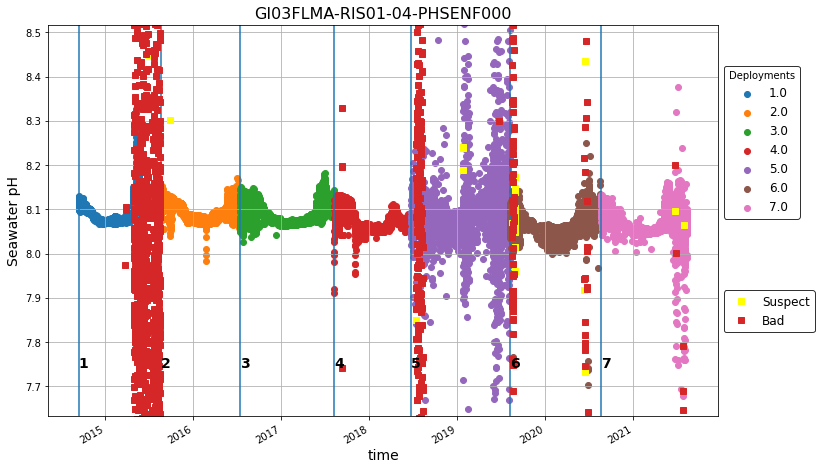

In [207]:
fig, ax = plotting.plot_variable(phsen_flma, "seawater_ph")

# Plot figure which highlights data points with a corresponding annotation
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s1, = ax.plot(phsen_flma.time.where(phsen_flma.qc_flags == 3), 
             phsen_flma.seawater_ph.where(phsen_flma.qc_flags == 3), 
             marker="s", linestyle="", color="yellow", label="Suspect")
s2, = ax.plot(phsen_flma.time.where(phsen_flma.qc_flags == 4), 
             phsen_flma.seawater_ph.where(phsen_flma.qc_flags == 4), 
             marker="s", linestyle="", color="tab:red", label="Bad")

ax.legend(handles=[s1, s2], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_title(refdes, fontsize=16)

In [208]:
if not os.path.exists(f"../results/{refdes}"):
    os.makedirs(f"../results/{refdes}")
    
fig.savefig(f"../results/{refdes}/time_series_with_quality_flags.png")

Drop the bad data

In [209]:
phsen_flma = phsen_flma.where(phsen_flma.qc_flags != 4, drop=True)

#### Match Bottle Data

In [210]:
deployments = OOINet.get_deployments(refdes)

lat, lon, depth = deployments["latitude"].mean(), deployments["longitude"].mean(), deployments["depth"].mean()
lat, lon, depth

(59.769139624999994, -39.862557124999995, 29.625)

In [211]:
phsen_flma_bottles = findSamples(carbonData, (lat, lon), depth, 5, 20)
phsen_flma_bottles

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pCO2 [lab conditions],Calculated pH [lab conditions]
82,AR35-05,13,GI03FLMA,59.761167,-39.883500,2019-08-15 20:04:17+00:00,13,*0000000000000101,2699.0,D:\Data\ar35-05013.hex,...,NaN,148.163162,NaN,NaN,34.851939,10.195864,1026.814513,1026.814513,706.826423,7.838931
140,AR7-01,8,FLMA,59.769500,-39.858667,2016-07-12 19:23:48+00:00,8,*0000000000000100,2721.0,D:\Data\ar0701008.hex,...,NaN,148.867229,NaN,NaN,35.012560,7.496073,1027.371124,1027.371124,713.999197,7.839385
249,AR21,11,FLMA,59.769667,-39.861000,2017-08-08 15:55:08+00:00,11,*0000000000000100,2720.0,D:\Data\AR21_011.hex,...,NaN,146.427996,NaN,NaN,35.014135,7.109681,1027.449318,1027.449318,724.704146,7.833390
498,AT30-01,10,GI03FLMA-2,59.761833,-39.880667,2015-08-19 21:15:33+00:00,10,*0000000000000100,2690.0,C:\data\ctd\at30_010.hex,...,NaN,123.710966,NaN,NaN,35.117941,5.340275,1027.756433,1027.756433,892.124610,7.754857
643,AR30-03,7,FLMA,59.770667,-39.859000,2018-06-10 14:37:43+00:00,7,*0000000000000100,2720.0,D:\Data\ar30-03007.hex,...,NaN,116.394532,NaN,NaN,35.025455,5.038746,1027.701504,1027.701504,937.137881,7.732569


In [275]:
phsen_flma.attrs["id"]

'GI03FLMA-RIS01-04-PHSENF000-recovered_inst-phsen_abcdef_instrument'

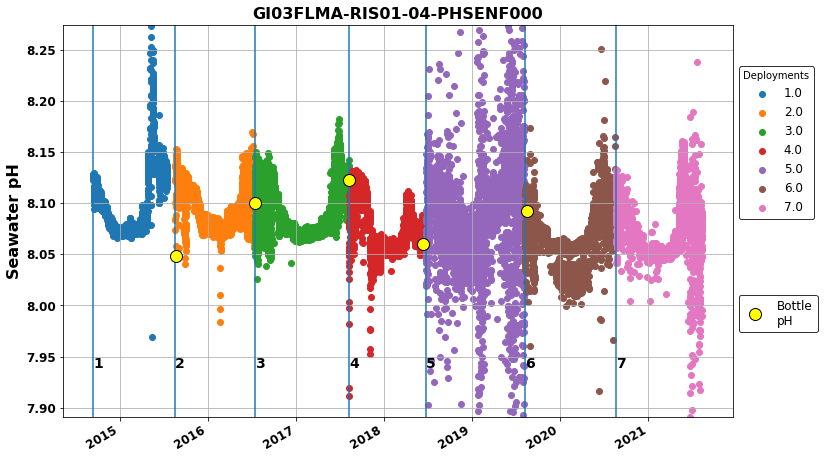

In [276]:
refdes = "GI03FLMA-RIS01-04-PHSENF000"
fig, ax = plotting.plot_variable(phsen_flma, "seawater_ph")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

s, = ax.plot(phsen_flma_bottles.dropna(subset=["Calculated pH"])["Start Time [UTC]"], 
             phsen_flma_bottles.dropna(subset=["Calculated pH"])["Calculated pH"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle\npH")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_xlim(xmin, xmax)
ax.set_title(refdes, fontsize=16, weight="bold")
ylabel = ax.yaxis.get_label_text()
ax.set_ylabel(ylabel, fontsize=16, weight="bold")
ax.set_xlabel("")


for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

In [277]:
if not os.path.exists(f"../results/{refdes}"):
    os.makedirs(f"../results/{refdes}")
    
fig.savefig(f"../results/{refdes}/time_series_with_discrete_bottles.png", facecolor="white", transparent=False)

#### Bottle vs. Instrument Comparison

In [214]:
phsen_flma_comparison = pd.DataFrame(columns=["deploymentNumber", "time", "PH_avg", "PH_std", "T", "S", "P",
                                            "bottlePH", "bottleT", "bottleS", "bottleP"])

for ind in phsen_flma_bottles.index:
    # Get the time stamps of a bottle
    t = phsen_flma_bottles["Start Time [UTC]"].loc[ind]
    t = t.tz_localize(None)

    # Get the bottle pCO2a
    bottlePH = phsen_flma_bottles["Calculated pH"].loc[ind]
    bottleT = phsen_flma_bottles[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].loc[ind].mean(skipna=True)
    bottleS = phsen_flma_bottles[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].loc[ind].mean(skipna=True)
    bottleP = phsen_flma_bottles["CTD Pressure [db]"].loc[ind]

    # Create a time window to look for data
    dt = pd.Timedelta(days=7)
    tmin = t - dt
    tmax = t + dt

    # Find the data within the time series
    subset = phsen_flma.where((phsen_flma.time >= tmin) & (phsen_flma.time <= tmax), drop=True)
    # Check for unique deployments
    deps = np.unique(subset.deployment)
    # If more than one deployment, split it based on deployments
    if len(deps) > 1:
        for depNum in deps:
            dep_subset = subset.where(subset.deployment == depNum, drop=True)
            pco2_avg = dep_subset.seawater_ph.mean(skipna=True).compute().values
            pco2_std = dep_subset.seawater_ph.std(skipna=True).compute().values
            pco2_temp = dep_subset.seawater_temperature.mean().compute().values
            pco2_sal = dep_subset.practical_salinity.mean().compute().values
            pco2_pres = dep_subset.seawater_pressure.mean().compute().values
            phsen_flma_comparison = phsen_flma_comparison.append({
                    "deploymentNumber": depNum,
                    "time": t,
                    "PH_avg": pco2_avg,
                    "PH_std": pco2_std,
                    "T": pco2_temp,
                    "S": pco2_sal,
                    "P": pco2_pres,
                    "bottlePH": bottlePH,
                    "bottleT": bottleT,
                    "bottleS": bottleS,
                    "bottleP": bottleP,
                }, ignore_index=True)
    elif len(deps) == 1:
        pco2_avg = subset.seawater_ph.mean(skipna=True).compute().values
        pco2_std = subset.seawater_ph.std(skipna=True).compute().values
        pco2_temp = subset.seawater_temperature.mean().compute().values
        pco2_sal = subset.practical_salinity.mean().compute().values
        pco2_pres = subset.seawater_pressure.mean().compute().values
        depNum = deps[0]
        phsen_flma_comparison = phsen_flma_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "PH_avg": pco2_avg,
                "PH_std": pco2_std,
                "T": pco2_temp,
                "S": pco2_sal,
                "P": pco2_pres,
                "bottlePH": bottlePH,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)
    else:
        # Now put in NaNs for the missing results data
        phsen_flma_comparison = phsen_flma_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "PH_avg": None,
                "PH_std": None,
                "T": None,
                "S": None,
                "P": None,
                "bottlePH": bottlePH,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)

# Save the results
phsen_flma_comparison

,deploymentNumber,time,PH_avg,PH_std,T,S,P,bottlePH,bottleT,bottleS,bottleP
0,6.0,2019-08-15 20:04:17,8.062283286660454,0.041453773439083484,7.254520562977062,34.76834714438321,37.21301693216684,8.092627,10.20385,34.68695,30.656
1,2.0,2016-07-12 19:23:48,8.125710374347676,0.021656040952879457,6.720046461664115,34.85650310563181,36.22467729776214,8.100519,7.50540,34.84680,31.117
2,3.0,2016-07-12 19:23:48,8.101507493101826,0.028599548110323256,6.473287883111716,34.879253923404086,33.26994980995494,8.100519,7.50540,34.84680,31.117
3,3.0,2017-08-08 15:55:08,8.126361272771712,0.007865394228557242,7.44987148540671,34.94769978914938,31.567571963154716,8.122894,7.11915,34.84825,35.870
4,4.0,2017-08-08 15:55:08,8.078207378969951,0.03772620197669014,6.2284385070060395,34.88477327868336,38.49719343418262,8.122894,7.11915,34.84825,35.870
5,2.0,2015-08-19 21:15:33,8.130198285138123,0.01669561930831313,7.275057580653094,34.91767975700787,41.592962398515276,8.047903,5.34910,34.95160,34.440
6,4.0,2018-06-10 14:37:43,8.075852275355697,0.004004118154852124,4.662916077269073,34.85412339905132,37.41869735094454,8.060404,5.04580,34.85965,30.496


Plot the comparison

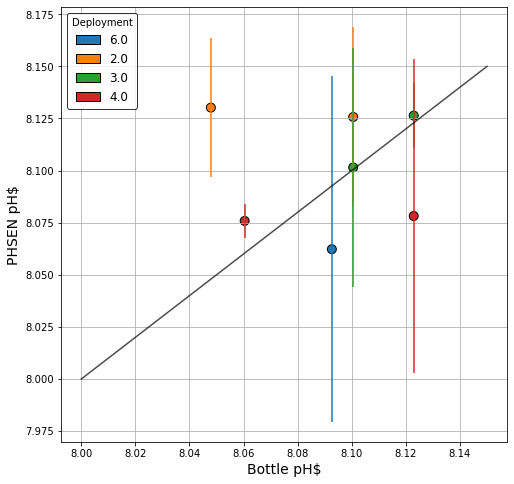

In [215]:
df = phsen_flma_comparison.dropna(subset=["deploymentNumber"])
df["bottlePH"] = df["bottlePH"].astype(float)
df["PH_avg"] = df["PH_avg"].astype(float)
df["PH_std"] = df["PH_std"].astype(float)
#df = df[df["deploymentNumber"] != 3]

fig, ax = plt.subplots(figsize=(8,8))

# Set the 
levels, categories = pd.factorize(df['deploymentNumber'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data
ax.scatter(df["bottlePH"], df["PH_avg"], c=colors, s=80, edgecolors="black")
ax.set_xlabel(xlabel="Bottle pH$", fontsize=14)
ax.set_ylabel(ylabel="PHSEN pH$", fontsize=14)
ax.legend(handles=handles, title='Deployment', fontsize=12, edgecolor="black")
ax.grid()

# Add in vertical error bars
for i, c in enumerate(categories):
    x = df["bottlePH"][df["deploymentNumber"] == c]
    ymin = df["PH_avg"][df["deploymentNumber"] == c] - 2*df["PH_std"][df["deploymentNumber"] == c]
    ymax = df["PH_avg"][df["deploymentNumber"] == c] + 2*df["PH_std"][df["deploymentNumber"] == c]
    ax.vlines(x, ymin, ymax, colors = plt.cm.tab10(i))

#ax.set_ylim((250, 500))
#ax.set_xlim((350, 450))
# Add in a 1:1 line
x = np.arange(8, 8.2, 0.05)
y = np.arange(8, 8.2, 0.05)
ax.plot(x, y, color = "black", alpha=0.7)

In [216]:
fig.savefig(f"../results/{refdes}/instrument_vs_bottle_comparison.png")

### FLMB

In [217]:
import process_pco2w, process_phsen

Text(0.5, 1.0, 'GI03FLMB-RIS01-04-PHSENF000')

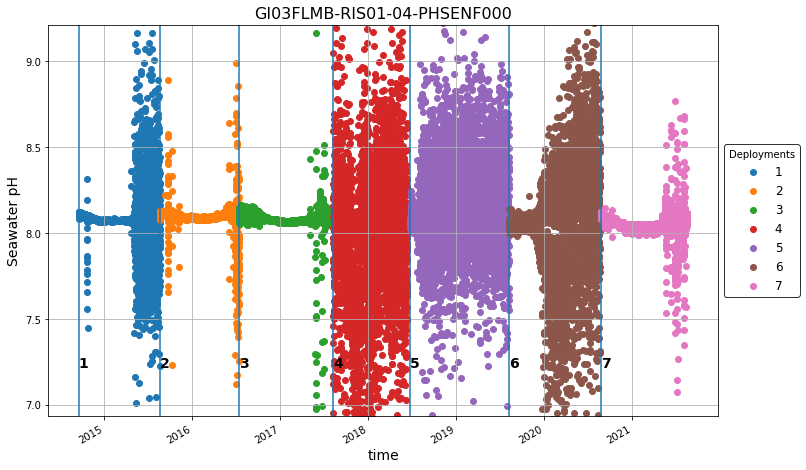

In [218]:
refdes = "GI03FLMB-RIS01-04-PHSENF000"

phsen_flmb = xr.open_dataset("../data/GI03FLMB-RIS01-04-PHSENF000/GI03FLMB-RIS01-04-PHSENF000-recovered_inst-phsen_abcdef_instrument.nc", chunks="auto")
phsen_flmb = process_phsen.phsen_instrument(phsen_flmb)

annotations = OOINet.get_annotations(refdes)

phsen_flmb = OOINet.add_annotation_qc_flag(phsen_flmb, annotations)

#phsen_flmb = phsen_flmb.where(phsen_flmb.rollup_annotations_qc_results != 9, drop=True)

fig, ax = plotting.plot_variable(phsen_flmb, "seawater_ph")
ax.set_title(refdes, fontsize=16)

In [219]:
phsen_flmb

<xarray.Dataset>
Dimensions:                        (time: 30089, blanks: 4, measurements: 23)
Coordinates:
  * time                           (time) datetime64[ns] 2014-09-16T18:00:00 ...
  * measurements                   (measurements) int32 0 1 2 3 ... 19 20 21 22
  * blanks                         (blanks) int32 0 1 2 3
Data variables: (12/19)
    deployment                     (time) int32 dask.array<chunksize=(30089,), meta=np.ndarray>
    seawater_ph                    (time) float64 dask.array<chunksize=(30089,), meta=np.ndarray>
    seawater_ph_qc_executed        (time) float32 dask.array<chunksize=(30089,), meta=np.ndarray>
    seawater_ph_qc_results         (time) float32 dask.array<chunksize=(30089,), meta=np.ndarray>
    thermistor_temperature         (time) float64 dask.array<chunksize=(30089,), meta=np.ndarray>
    practical_salinity             (time) float64 dask.array<chunksize=(30089,), meta=np.ndarray>
    ...                             ...
    blank_signal_578               (time, blanks) int32 2625 2626 ... 1585 1586
    reference_434                  (time, measurements) int32 3395 3397 ... 2407
    signal_434                     (time, measurements) int32 2021 2019 ... 1367
    reference_578                  (time, measurements) int32 2621 2625 ... 1679
    signal_578                     (time, measurements) int32 2624 2624 ... 1471
    seawater_ph_quality_flag       (time) int32 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
Attributes: (12/70)
    node:                               RIS01
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_inst
    stream:                             phsen_abcdef_instrument
    ...                                 ...
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                59.7128
    lon:                                -39.3204
    Location_name:                      Global Irminger Sea Flanking Subsurfa...

In [220]:
if not os.path.exists(f"../results/{refdes}"):
    os.makedirs(f"../results/{refdes}")
    
fig.savefig(f"../results/{refdes}/time_series.png")

#### CTD Data
Add in the CTD data from the colocated CTD in order to get the seawater temperature and pressure (salinity is included in teh data stream)

In [221]:
ctdmo_flmb = xr.open_dataset("../data/GI03FLMB-RIM01-02-CTDMOG060_combined.nc", chunks="auto")

seawater_temperature = ctdmo_flmb["ctdmo_seawater_temperature"].interp_like(phsen_flmb)
seawater_pressure = ctdmo_flmb["ctdmo_seawater_pressure"].interp_like(phsen_flmb)

# Add to the pco2w
phsen_flmb["seawater_temperature"] = seawater_temperature
phsen_flmb["seawater_pressure"] = seawater_pressure

#### Quality Checks
Next, add in the quality checks for the data

In [222]:
qc_flags = process_phsen.quality_checks(phsen_flmb)
phsen_flmb["qc_flags"] = qc_flags

Text(0.5, 1.0, 'GI03FLMB-RIS01-04-PHSENF000')

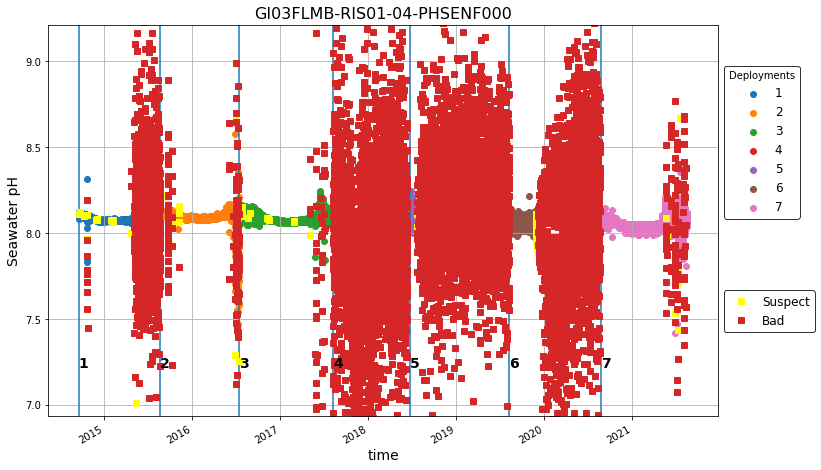

In [223]:
fig, ax = plotting.plot_variable(phsen_flmb, "seawater_ph")

# Plot figure which highlights data points with a corresponding annotation
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s1, = ax.plot(phsen_flmb.time.where(phsen_flmb.qc_flags == 3), 
             phsen_flmb.seawater_ph.where(phsen_flmb.qc_flags == 3), 
             marker="s", linestyle="", color="yellow", label="Suspect")
s2, = ax.plot(phsen_flmb.time.where(phsen_flmb.qc_flags == 4), 
             phsen_flmb.seawater_ph.where(phsen_flmb.qc_flags == 4), 
             marker="s", linestyle="", color="tab:red", label="Bad")

ax.legend(handles=[s1, s2], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_title(refdes, fontsize=16)

In [224]:
if not os.path.exists(f"../results/{refdes}"):
    os.makedirs(f"../results/{refdes}")
    
fig.savefig(f"../results/{refdes}/time_series_with_quality_flags.png")

Drop the bad data

In [225]:
phsen_flmb = phsen_flmb.where(phsen_flmb.qc_flags != 4, drop=True)

#### Match Bottle Data

In [226]:
deployments = OOINet.get_deployments(refdes)

lat, lon, depth = deployments["latitude"].mean(), deployments["longitude"].mean(), deployments["depth"].mean()
lat, lon, depth

(59.71661225, -39.334329999999994, 29.25)

In [227]:
phsen_flmb_bottles = findSamples(carbonData, (lat, lon), depth, 5, 20)
phsen_flmb_bottles

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pCO2 [lab conditions],Calculated pH [lab conditions]
19,AR35-05,10,GI03FLMB,59.718317,-39.336800,2019-08-12 08:22:00+00:00,10,*0000000000000001,2817.0,NaN,...,NaN,132.623216,NaN,NaN,34.865036,8.232593,1027.141450,1027.141450,807.570623,7.788800
59,AR35-05,12,GI03FLMB,59.712333,-39.361333,2019-08-15 15:39:18+00:00,12,*0000000000000101,2816.0,D:\Data\ar35-05012.hex,...,NaN,148.828246,NaN,NaN,34.727794,10.164031,1026.722411,1026.722411,694.965003,7.844141
153,AR7-01,9,FLMB,59.716833,-39.336000,2016-07-13 16:20:08+00:00,9,*0000000000000100,2848.0,D:\Data\ar0701009.hex,...,NaN,126.435781,NaN,NaN,35.064236,4.642131,1027.776784,1027.776784,864.950166,7.766937
237,AR21,10,FLMB,59.716167,-39.338167,2017-08-07 16:14:21+00:00,10,*0000000000000100,2848.0,D:\Data\AR21_010.hex,...,NaN,132.856216,NaN,NaN,35.093319,6.236875,1027.631968,1027.631968,822.399106,7.786025
486,AT30-01,9,GI03FLMB-1,59.706667,-39.332000,2015-08-19 15:06:00+00:00,9,*0000000000000100,2823.0,C:\data\ctd\at30_009.hex,...,NaN,147.974854,NaN,NaN,35.017883,7.937053,1027.318768,1027.318768,716.756138,7.836911
511,AT30-01,11,GI03FLMB-2,59.686500,-39.365500,2015-08-21 19:14:51+00:00,11,*0000000000000100,2830.0,C:\data\ctd\at30_011.hex,...,NaN,144.867718,NaN,NaN,35.011769,7.583976,1027.368838,1027.368838,735.676315,7.827224
770,AR30-03,15,FLMB,59.717500,-39.338500,2018-06-16 13:54:45+00:00,15,*0000000000000100,2825.0,D:\Data\ar30-03015.hex,...,NaN,118.684898,NaN,NaN,35.004613,4.985486,1027.692057,1027.692057,912.181158,7.742494


Text(0.5, 1.0, 'GI03FLMB-RIS01-04-PHSENF000')

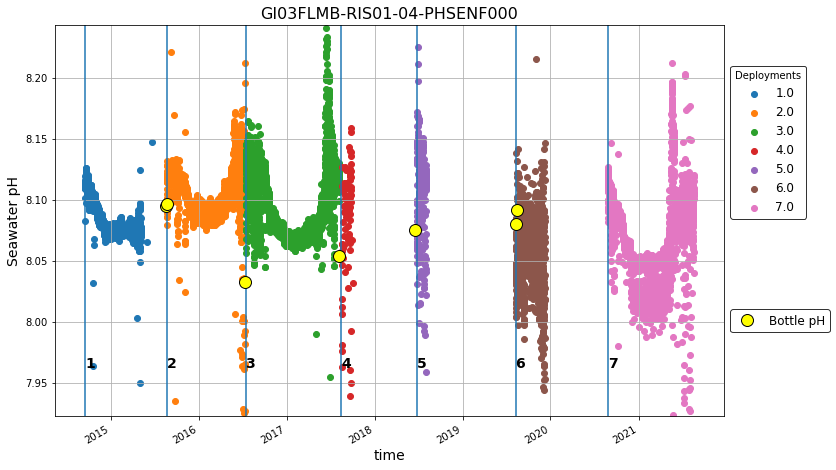

In [228]:
fig, ax = plotting.plot_variable(phsen_flmb, "seawater_ph")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

s, = ax.plot(phsen_flmb_bottles.dropna(subset=["Calculated pH"])["Start Time [UTC]"], 
             phsen_flmb_bottles.dropna(subset=["Calculated pH"])["Calculated pH"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle pH")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_xlim(xmin, xmax)
ax.set_title(refdes, fontsize=16)

In [229]:
if not os.path.exists(f"../results/{refdes}"):
    os.makedirs(f"../results/{refdes}")
    
fig.savefig(f"../results/{refdes}/time_series_with_discrete_bottles.jpg", format="jpg")

#### Bottle vs. Instrument Comparison

In [230]:
phsen_flmb_comparison = pd.DataFrame(columns=["deploymentNumber", "time", "PH_avg", "PH_std", "T", "S", "P",
                                            "bottlePH", "bottleT", "bottleS", "bottleP"])

for ind in phsen_flmb_bottles.index:
    # Get the time stamps of a bottle
    t = phsen_flmb_bottles["Start Time [UTC]"].loc[ind]
    t = t.tz_localize(None)

    # Get the bottle pCO2a
    bottlePH = phsen_flmb_bottles["Calculated pH"].loc[ind]
    bottleT = phsen_flmb_bottles[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].loc[ind].mean(skipna=True)
    bottleS = phsen_flmb_bottles[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].loc[ind].mean(skipna=True)
    bottleP = phsen_flmb_bottles["CTD Pressure [db]"].loc[ind]

    # Create a time window to look for data
    dt = pd.Timedelta(days=7)
    tmin = t - dt
    tmax = t + dt

    # Find the data within the time series
    subset = phsen_flmb.where((phsen_flmb.time >= tmin) & (phsen_flmb.time <= tmax), drop=True)
    # Check for unique deployments
    deps = np.unique(subset.deployment)
    # If more than one deployment, split it based on deployments
    if len(deps) > 1:
        for depNum in deps:
            dep_subset = subset.where(subset.deployment == depNum, drop=True)
            pco2_avg = dep_subset.seawater_ph.mean(skipna=True).compute().values
            pco2_std = dep_subset.seawater_ph.std(skipna=True).compute().values
            pco2_temp = dep_subset.seawater_temperature.mean().compute().values
            pco2_sal = dep_subset.practical_salinity.mean().compute().values
            pco2_pres = dep_subset.seawater_pressure.mean().compute().values
            phsen_flmb_comparison = phsen_flmb_comparison.append({
                    "deploymentNumber": depNum,
                    "time": t,
                    "PH_avg": pco2_avg,
                    "PH_std": pco2_std,
                    "T": pco2_temp,
                    "S": pco2_sal,
                    "P": pco2_pres,
                    "bottlePH": bottlePH,
                    "bottleT": bottleT,
                    "bottleS": bottleS,
                    "bottleP": bottleP,
                }, ignore_index=True)
    elif len(deps) == 1:
        pco2_avg = subset.seawater_ph.mean(skipna=True).compute().values
        pco2_std = subset.seawater_ph.std(skipna=True).compute().values
        pco2_temp = subset.seawater_temperature.mean().compute().values
        pco2_sal = subset.practical_salinity.mean().compute().values
        pco2_pres = subset.seawater_pressure.mean().compute().values
        depNum = deps[0]
        phsen_flmb_comparison = phsen_flmb_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "PH_avg": pco2_avg,
                "PH_std": pco2_std,
                "T": pco2_temp,
                "S": pco2_sal,
                "P": pco2_pres,
                "bottlePH": bottlePH,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)
    else:
        # Now put in NaNs for the missing results data
        phsen_flmb_comparison = phsen_flmb_comparison.append({
                "deploymentNumber": depNum,
                "time": t,
                "PH_avg": None,
                "PH_std": None,
                "T": None,
                "S": None,
                "P": None,
                "bottlePH": bottlePH,
                "bottleT": bottleT,
                "bottleS": bottleS,
                "bottleP": bottleP,
            }, ignore_index=True)

# Save the results
phsen_flmb_comparison

,deploymentNumber,time,PH_avg,PH_std,T,S,P,bottlePH,bottleT,bottleS,bottleP
0,6.0,2019-08-12 08:22:00,8.055496386771043,0.02787901870951448,6.9408497624859,34.69977084505789,39.30431456769488,8.079797,8.24000,34.70000,30.000
1,6.0,2019-08-15 15:39:18,8.054833666063079,0.027091516355765313,6.9501706127085585,34.68893036808708,38.82252143702801,8.091812,10.16965,34.56340,30.297
2,2.0,2016-07-13 16:20:08,7.8693292957579235,0.21163167082465242,6.398616772584283,34.84090884845963,31.581698488728176,8.032627,4.64915,34.89825,30.274
3,3.0,2016-07-13 16:20:08,8.118588471651869,0.018746510205746855,7.184917959292452,34.839346077411264,29.754515929091646,8.032627,4.64915,34.89825,30.274
4,3.0,2017-08-07 16:14:21,8.117888497918175,0.005616861508854159,7.429678460751962,34.79843819340975,26.89497972211895,8.053940,6.24660,34.92705,36.246
5,4.0,2017-08-07 16:14:21,8.338739996638147,0.0,6.451096091237871,34.844896388852625,48.96800689194151,8.053940,6.24660,34.92705,36.246
6,2.0,2015-08-19 15:06:00,8.114206636755993,0.010559709609256895,7.918497135023236,34.89172393082495,35.03836703537448,8.094675,7.94700,34.85205,32.991
7,2.0,2015-08-21 19:14:51,8.115394465522815,0.009054094172498292,8.062350722184796,34.88032366831827,34.825802582645636,8.096604,7.59360,34.84595,33.558
8,2.0,2018-06-16 13:54:45,None,None,None,None,None,8.075072,4.99225,34.83890,30.651


Plot the comparison

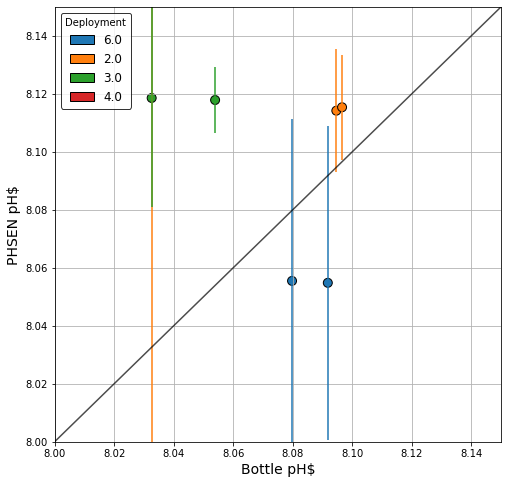

In [231]:
df = phsen_flmb_comparison.dropna(subset=["deploymentNumber"])
df["bottlePH"] = df["bottlePH"].astype(float)
df["PH_avg"] = df["PH_avg"].astype(float)
df["PH_std"] = df["PH_std"].astype(float)
#df = df[df["deploymentNumber"] != 3]

fig, ax = plt.subplots(figsize=(8,8))

# Set the 
levels, categories = pd.factorize(df['deploymentNumber'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data
ax.scatter(df["bottlePH"], df["PH_avg"], c=colors, s=80, edgecolors="black")
ax.set_xlabel(xlabel="Bottle pH$", fontsize=14)
ax.set_ylabel(ylabel="PHSEN pH$", fontsize=14)
ax.legend(handles=handles, title='Deployment', fontsize=12, edgecolor="black")
ax.grid()

# Add in vertical error bars
for i, c in enumerate(categories):
    x = df["bottlePH"][df["deploymentNumber"] == c]
    ymin = df["PH_avg"][df["deploymentNumber"] == c] - 2*df["PH_std"][df["deploymentNumber"] == c]
    ymax = df["PH_avg"][df["deploymentNumber"] == c] + 2*df["PH_std"][df["deploymentNumber"] == c]
    ax.vlines(x, ymin, ymax, colors = plt.cm.tab10(i))

ax.set_ylim((8, 8.15))
ax.set_xlim((8, 8.15))
# Add in a 1:1 line
x = np.arange(8, 8.205, 0.05)
y = np.arange(8, 8.205, 0.05)
ax.plot(x, y, color = "black", alpha=0.7)

In [232]:
fig.savefig(f"../results/{refdes}/instrument_vs_bottle_comparison.png")

### PHSEN Comparison
Now, combine all of the phsen instruments and compare with one another

Text(0.5, 0, '')

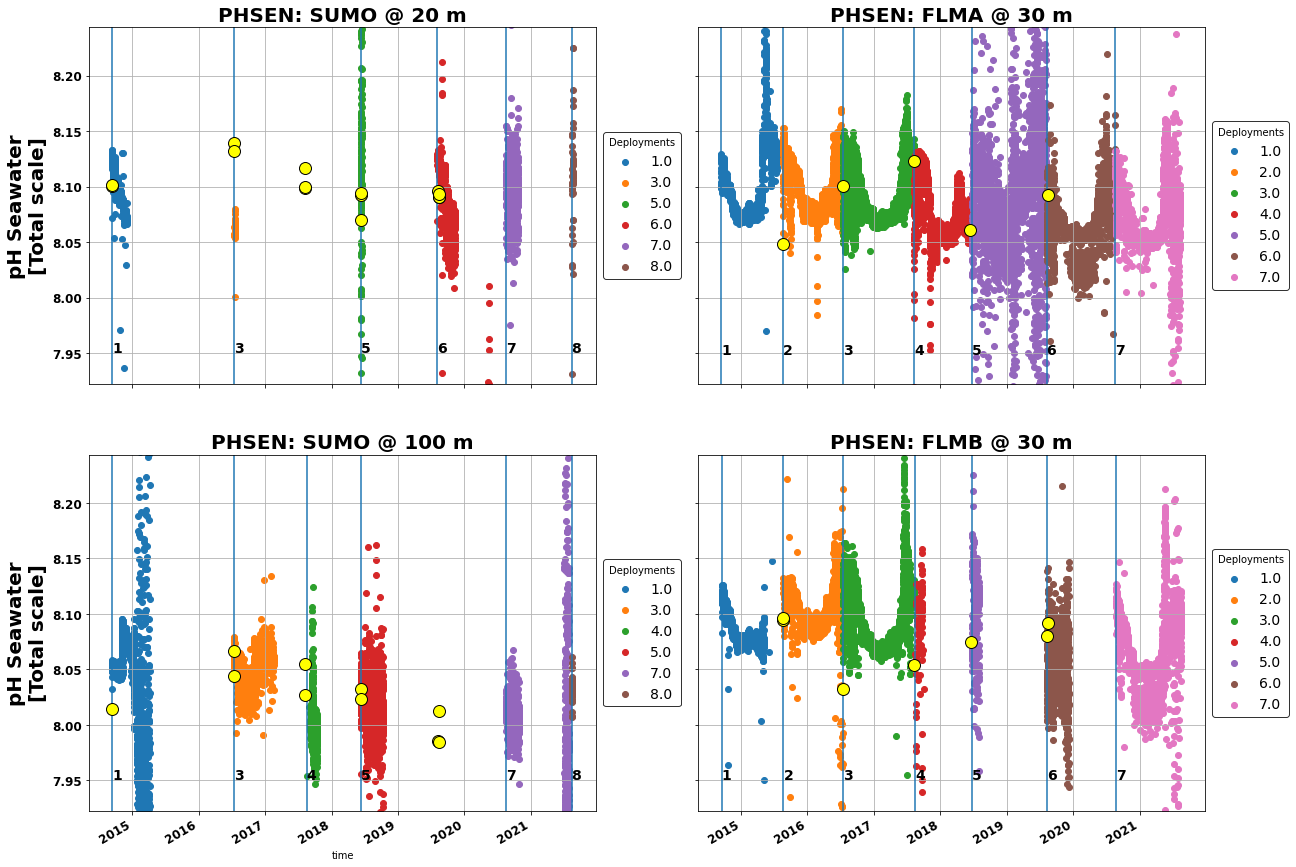

In [238]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 16), sharex=True, sharey=True)

param = "seawater_ph"

# Plot the 20 m SUMO PHSEN
# ------------------------
# Calculate the figure bounds
yavg, ystd, ymin, ymax = calculate_ylims(phsen_20m, param)

# Generate the plot figure
s = phsen_20m.plot.scatter("time", param, ax=ax[0][0], hue="deployment", hue_style="discrete")

# Add the deployments
ax[0][0].legend(edgecolor="black", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title="Deployments")
deployments = np.unique(phsen_20m["deployment"])
for depNum in deployments:
    dt = phsen_20m.where(phsen_20m["deployment"] == depNum, drop=True)["time"].min()
    ax[0][0].vlines(dt.values, yavg-4*ystd, yavg+4*ystd)
    ax[0][0].text(dt.values, yavg-1.5*ystd, str(int(depNum)), fontsize=14, weight="bold")
xmin, xmax = ax[0][0].get_xlim()

# Add the bottle samples
b, = ax[0][0].plot(phsen_20m_bottles.dropna(subset=["Calculated pH"])["Start Time [UTC]"], 
             phsen_20m_bottles.dropna(subset=["Calculated pH"])["Calculated pH"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle\npH")
#ax[0].legend(handles=[b], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)


# Set the ylims
ax[0][0].set_xlim(xmin, xmax)
ax[0][0].set_ylim(ymin, ymax)
ax[0][0].grid()
ax[0][0].set_title("PHSEN: SUMO @ 20 m", fontsize=20, weight="bold")
ax[0][0].set_ylabel("pH Seawater\n[Total scale]", fontsize=20, weight="bold")
#plt.yticks(fontsize=12, weight="bold")

for tick in ax[0][0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")


# Plot the 100 m SUMO PHSEN
# ------------------------
# Calculate the figure bounds
yavg, ystd, ymin, ymax = calculate_ylims(phsen_100m, param)

# Generate the plot figure
s = phsen_100m.plot.scatter("time", param, ax=ax[1][0], hue="deployment", hue_style="discrete")

# Add the deployments
ax[1][0].legend(edgecolor="black", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title="Deployments")
deployments = np.unique(phsen_100m["deployment"])
for depNum in deployments:
    dt = phsen_100m.where(phsen_100m["deployment"] == depNum, drop=True)["time"].min()
    ax[1][0].vlines(dt.values, yavg-4*ystd, yavg+4*ystd)
    ax[1][0].text(dt.values, yavg-1.25*ystd, str(int(depNum)), fontsize=14, weight="bold")
xmin, xmax = ax[1][0].get_xlim()

# Add the bottle samples
b, = ax[1][0].plot(phsen_100m_bottles.dropna(subset=["Calculated pH"])["Start Time [UTC]"], 
             phsen_100m_bottles.dropna(subset=["Calculated pH"])["Calculated pH"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle\npH")
#ax[0].legend(handles=[b], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
for tick in ax[1][0].xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax[1][0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

# Set the ylims
ax[1][0].set_xlim(xmin, xmax)
ax[1][0].set_ylim(ymin, ymax)
ax[1][0].grid()
ax[1][0].set_title("PHSEN: SUMO @ 100 m", fontsize=20, weight="bold")
ax[1][0].set_ylabel("pH Seawater\n[Total scale]", fontsize=20, weight="bold")
#plt.yticks(fontsize=12, weight="bold")

# Plot the FLMA PHSEN
# ------------------------
# Calculate the figure bounds
yavg, ystd, ymin, ymax = calculate_ylims(phsen_flma, param)

# Generate the plot figure
s = phsen_flma.plot.scatter("time", param, ax=ax[0][1], hue="deployment", hue_style="discrete")

# Add the deployments
ax[0][1].legend(edgecolor="black", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title="Deployments")
deployments = np.unique(phsen_flma["deployment"])
for depNum in deployments:
    dt = phsen_flma.where(phsen_flma["deployment"] == depNum, drop=True)["time"].min()
    ax[0][1].vlines(dt.values, yavg-4*ystd, yavg+4*ystd)
    ax[0][1].text(dt.values, yavg-2.8*ystd, str(int(depNum)), fontsize=14, weight="bold")
xmin, xmax = ax[0][1].get_xlim()

# Add the bottle samples
b, = ax[0][1].plot(phsen_flma_bottles.dropna(subset=["Calculated pH"])["Start Time [UTC]"], 
             phsen_flma_bottles.dropna(subset=["Calculated pH"])["Calculated pH"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle\npH")
#ax[0].legend(handles=[b], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)


# Set the ylims
ax[0][1].set_xlim(xmin, xmax)
ax[0][1].set_ylim(ymin, ymax)
ax[0][1].grid()
ax[0][1].set_title("PHSEN: FLMA @ 30 m", fontsize=20, weight="bold")
ax[0][1].set_ylabel(None)


#plt.yticks(fontsize=12, weight="bold")

# Plot the FLMB PHSEN
# ------------------------
# Calculate the figure bounds
yavg, ystd, ymin, ymax = calculate_ylims(phsen_flmb, param)

# Generate the plot figure
s = phsen_flmb.plot.scatter("time", param, ax=ax[1][1], hue="deployment", hue_style="discrete")

# Add the deployments
ax[1][1].legend(edgecolor="black", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title="Deployments")
deployments = np.unique(phsen_flmb["deployment"])
for depNum in deployments:
    dt = phsen_flmb.where(phsen_flmb["deployment"] == depNum, drop=True)["time"].min()
    ax[1][1].vlines(dt.values, yavg-4*ystd, yavg+4*ystd)
    ax[1][1].text(dt.values, yavg-3.3*ystd, str(int(depNum)), fontsize=14, weight="bold")
xmin, xmax = ax[1][1].get_xlim()

# Add the bottle samples
b, = ax[1][1].plot(phsen_flmb_bottles.dropna(subset=["Calculated pH"])["Start Time [UTC]"], 
             phsen_flmb_bottles.dropna(subset=["Calculated pH"])["Calculated pH"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle\npH")
#ax[0].legend(handles=[b], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)


# Set the ylims
ax[1][1].set_xlim(xmin, xmax)
ax[1][1].set_ylim(ymin, ymax)
ax[1][1].grid()
ax[1][1].set_title("PHSEN: FLMB @ 30 m", fontsize=20, weight="bold")
ax[1][1].set_ylabel(None)

for tick in ax[1][1].xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

fig.autofmt_xdate()
plt.xlabel("")

In [239]:
fig.savefig("../results/PHSEN_time_series_all.png", facecolor="white", transparent=False)

In [241]:
phsen_20m_comparison["instrument"] = "sumo_20m"
phsen_100m_comparison["instrument"] = "sumo_100m"
phsen_flma_comparison["instrument"] = "flma"
phsen_flmb_comparison["instrument"] = "flmb"
phsen_comparison = phsen_20m_comparison.append(phsen_100m_comparison).append(phsen_flma_comparison).append(phsen_flmb_comparison)
phsen_comparison.to_excel("../results/PHSEN_comparison.xlsx", index=False)

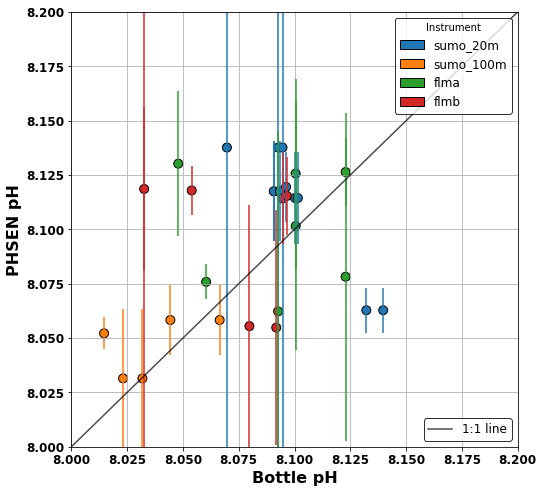

In [253]:
df = phsen_comparison.dropna(subset=["deploymentNumber"])
df["bottlePH"] = df["bottlePH"].astype(float)
df["PH_avg"] = df["PH_avg"].astype(float)
df["PH_std"] = df["PH_std"].astype(float)
#df = df[df["deploymentNumber"] != 3]

fig, ax = plt.subplots(figsize=(8,8))

# Set the 
levels, categories = pd.factorize(df['instrument'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data
ax.scatter(df["bottlePH"], df["PH_avg"], c=colors, s=80, edgecolors="black")
ax.set_xlabel(xlabel="Bottle pH", fontsize=16, weight="bold")
ax.set_ylabel(ylabel="PHSEN pH", fontsize=16, weight="bold")
ax.legend(handles=handles, title='Instrument', fontsize=12, edgecolor="black", loc="upper right")
ax.grid()

first_legend = ax.get_legend()
ax.add_artist(first_legend)

# Add in vertical error bars
for i, c in enumerate(categories):
    x = df["bottlePH"][df["instrument"] == c]
    ymin = df["PH_avg"][df["instrument"] == c] - 2*df["PH_std"][df["instrument"] == c]
    ymax = df["PH_avg"][df["instrument"] == c] + 2*df["PH_std"][df["instrument"] == c]
    ax.vlines(x, ymin, ymax, colors = plt.cm.tab10(i))

ax.set_ylim((8, 8.2))
ax.set_xlim((8, 8.2))
# Add in a 1:1 line
x = np.arange(8, 8.205, 0.05)
y = np.arange(8, 8.205, 0.05)
s, = ax.plot(x, y, color = "black", alpha=0.7, label="1:1 line")
ax.legend(handles=[s], edgecolor="black", loc="lower right", fontsize=12)


for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    


In [254]:
fig.savefig("../results/phsen_comparison.png", facecolor="white", transparent=False)

## Here, add in the stuff about looking at deployment 3 of FLMA

In [255]:
flma_dep3 = phsen_flma.where(phsen_flma.deployment == 3, drop=True)
bottles3 = phsen_flma_comparison[phsen_flma_comparison["deploymentNumber"]==3]

In [256]:
bottles3

,deploymentNumber,time,PH_avg,PH_std,T,S,P,bottlePH,bottleT,bottleS,bottleP,instrument
2,3.0,2016-07-12 19:23:48,8.101507493101826,0.028599548110323256,6.473287883111716,34.879253923404086,33.26994980995494,8.100519,7.50540,34.84680,31.117,flma
3,3.0,2017-08-08 15:55:08,8.126361272771712,0.007865394228557242,7.44987148540671,34.94769978914938,31.567571963154716,8.122894,7.11915,34.84825,35.870,flma


In [257]:
dif3 = flma_dep3.seawater_ph.diff(dim="time").compute()
dif3

<xarray.DataArray 'seawater_ph' (time: 4699)>
array([-0.02633478,  0.05817997,  0.00233442, ..., -0.01164715,
       -0.03382163,  0.04546122])
Coordinates:
  * time     (time) datetime64[ns] 2016-07-13T01:59:59 ... 2017-08-08T13:59:59

In [258]:
dif3_std = dif3.std().values
dif3_std

array(0.01406455)

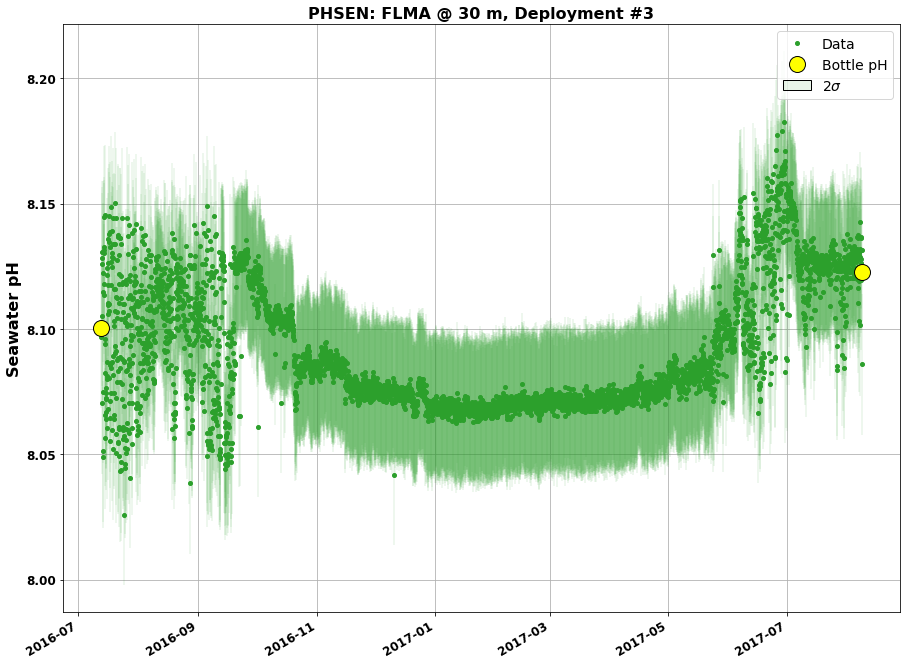

In [260]:
# Plot the time series with the difference value
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))

# Plot the data
ax.plot(flma_dep3["time"], flma_dep3[param], marker=".", linestyle="", color="tab:green", markersize=8, label="Data")
ax.vlines(flma_dep3["time"], flma_dep3[param]-2*dif3_std, flma_dep3[param]+2*dif3_std, color="tab:green", alpha=0.1, label="2$\sigma$")
ax.plot(bottles3["time"], bottles3["bottlePH"], marker="o", linestyle="", color="yellow", markersize=16, markeredgecolor="black", label="Bottle pH")
#s = flma_dep3.plot.scatter("time", param, ax=ax, hue="deployment", hue_style="discrete")
handles, labels = ax.get_legend_handles_labels()
handles[2] = matplotlib.patches.Patch(color=handles[2].get_color(), label=labels[2])
handles[2].set_edgecolor("black")
ax.legend(handles=handles, fontsize=14)
ax.grid()
ax.set_ylabel(flma_dep3[param].attrs["long_name"], fontsize=16, weight="bold")
ax.set_title("PHSEN: FLMA @ 30 m, Deployment #3", fontsize=16, weight="bold")
fig.autofmt_xdate()


for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

In [261]:
fig.savefig("../results/FLMA_PHSEN_Dep3_time_series_with_bottles.png", facecolor="white", transparent=False)

#### FLMA Deployment 4

In [262]:
flma_dep4 = phsen_flma.where(phsen_flma.deployment == 4, drop=True)
bottles4 = phsen_flma_comparison[phsen_flma_comparison["deploymentNumber"]==4]

In [263]:
bottles4

,deploymentNumber,time,PH_avg,PH_std,T,S,P,bottlePH,bottleT,bottleS,bottleP,instrument
4,4.0,2017-08-08 15:55:08,8.078207378969951,0.03772620197669014,6.2284385070060395,34.88477327868336,38.49719343418262,8.122894,7.11915,34.84825,35.870,flma
6,4.0,2018-06-10 14:37:43,8.075852275355697,0.004004118154852124,4.662916077269073,34.85412339905132,37.41869735094454,8.060404,5.04580,34.85965,30.496,flma


In [264]:
dif4 = flma_dep4.seawater_ph.diff(dim="time").compute()
dif4

<xarray.DataArray 'seawater_ph' (time: 3659)>
array([ 0.02653466,  0.01454502, -0.02131128, ..., -0.00567493,
       -0.00361678,  0.00418496])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-09T01:59:59 ... 2018-06-10T11:59:59

In [265]:
dif4_std = dif4.std().values
dif4_std

array(0.00859435)

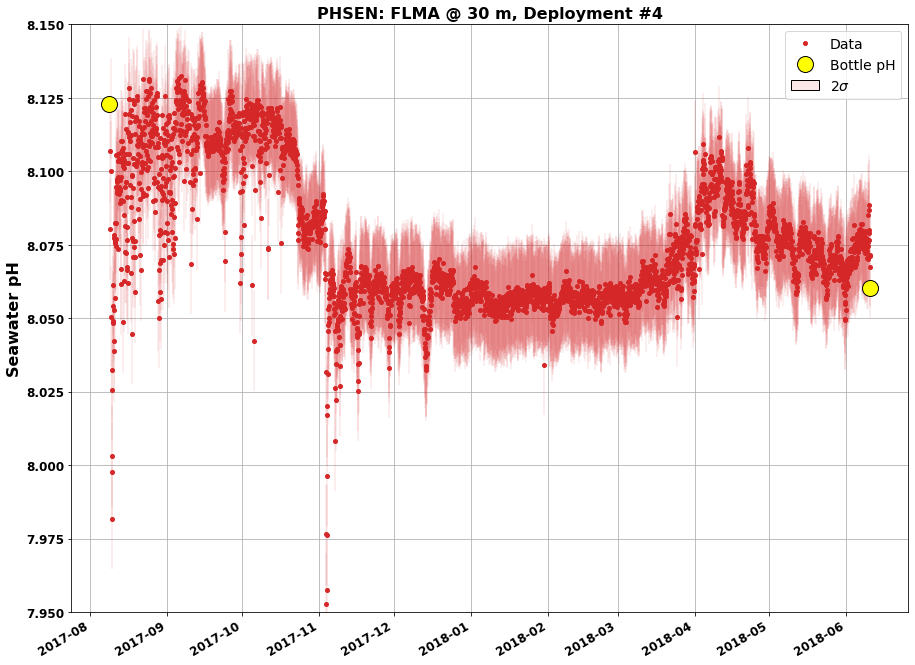

In [268]:
# Plot the time series with the difference value
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))

# Plot the data
ax.plot(flma_dep4["time"], flma_dep4[param], marker=".", linestyle="", color="tab:red", markersize=8, label="Data")
ax.vlines(flma_dep4["time"], flma_dep4[param]-2*dif4_std, flma_dep4[param]+2*dif4_std, color="tab:red", alpha=0.1, label="2$\sigma$")
ax.plot(bottles4["time"], bottles4["bottlePH"], marker="o", linestyle="", color="yellow", markersize=16, markeredgecolor="black", label="Bottle pH")
#s = flma_dep3.plot.scatter("time", param, ax=ax, hue="deployment", hue_style="discrete")
handles, labels = ax.get_legend_handles_labels()
handles[2] = matplotlib.patches.Patch(color=handles[2].get_color(), label=labels[2])
handles[2].set_edgecolor("black")
ax.legend(handles=handles, fontsize=14)
ax.grid()
ax.set_ylabel(flma_dep4[param].attrs["long_name"], fontsize=16, weight="bold")
ax.set_title("PHSEN: FLMA @ 30 m, Deployment #4", fontsize=16, weight="bold")
fig.autofmt_xdate()
ax.set_ylim((7.95, 8.15))


for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

In [269]:
fig.savefig("../results/FLMA_PHSEN_Dep4_time_series_with_bottles.png", facecolor="white", transparent=False)